# COVID-19 Detection in Chest X-Ray Images
The goal of this project is to develop a machine learning model that can classify chest X-ray images into three categories: COVID-19, Normal, and Pneumonia. The dataset, sourced from Mendeley, contains 603 images across these three classes. This notebook involves data preprocessing, Roboflow-assisted image cleaning, feature extraction (both pixel and texture-based), and classification using multiple ML models.

In [43]:
import os
import time
import zipfile
from glob import glob
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
from dotenv import load_dotenv
from roboflow import Roboflow
from skimage import io
from skimage.feature import graycomatrix, graycoprops
from skimage.transform import resize
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, roc_auc_score
from sklearn.inspection import permutation_importance
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler

### Set Constants
In this section, we load the necessary API keys (in this case, the Roboflow API key) from a .env file using the dotenv package. We also set a constant for random state, so that the analysis is reproducable.

In [ ]:
load_dotenv()
ROBOFLOW_KEY = os.getenv("ROBOFLOW_API_KEY")
# YOU WILL NEED YOUR OWN ROBOFLOW API KEY FOR RUNNING FROM SCRATCH
# ROBOFLOW_KEY = your_api_key_here

RANDOM_STATE = 42

## Download and Unzip Images
This step checks whether the dataset exists locally. If not, it downloads and unzips the dataset into a structured directory format. During extraction, file and folder names are sanitized for consistency.

In [ ]:
dataroot = "dataroot/"
zip_path = dataroot + "fvk7h5dg2p-1.zip"
raw_path = dataroot + "raw/"

def download_data(url):
    """
    Downloads a ZIP file from the specified URL and stores it in the 'dataroot' directory.

    Parameters:
    -----------
    url : str
        The direct download link to the ZIP file.

    Notes:
    ------
    - Assumes the ZIP contains a medical imaging dataset.
    - The resulting ZIP file is saved under 'dataroot/' and named according to zip_path.
    """
    response = requests.get(url, params={"downloadformat": "zip"})
    if not os.path.isdir(dataroot):
        os.makedirs(dataroot)
        with open(zip_path, "wb") as file:
            file.write(response.content)


def unzip_data():
    """
    Unzips the dataset stored at `zip_path` into the 'raw_path' directory.

    Notes:
    ------
    - Performs name sanitization for folders (e.g., "Normal " → "Normal").
    - Ensures directories exist before extraction.
    - Deletes the ZIP file after extraction to save space.
    """
    if os.path.isdir(dataroot):
        with zipfile.ZipFile(zip_path, "r") as zip_ref:
            for file in zip_ref.namelist():
                sanitized_name = file.strip().replace("\\", "/") #Ensure consistent path format
                #Sanitize folder name for "Normal "
                if sanitized_name.startswith("Normal "):
                    sanitized_name = sanitized_name.replace("Normal ", "Normal", 1)
                if sanitized_name.startswith("COVID-19"):
                    sanitized_name = sanitized_name.replace("COVID-19 cases", "COVID-19", 1)
            
                #Create the full target path within the 'Normal' folder
                target_path = os.path.join(raw_path, sanitized_name)

                #Skip directories (avoid trying to open them as files)
                if file.endswith("/"):
                    os.makedirs(target_path, exist_ok=True)
                    continue
            
                #Ensure the parent directory exists before extracting
                os.makedirs(os.path.dirname(target_path), exist_ok=True)

                # Extract file safely
                with zip_ref.open(file) as source, open(target_path, "wb") as target:
                    target.write(source.read())

        os.remove(zip_path) # Remove zip file
        print("Extraction completed successfully.")

In [46]:
# Download and unzip
if not os.path.isdir(dataroot):
    download_data("https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/fvk7h5dg2p-1.zip")
    unzip_data()
else:
    print("dataroot already exists.")

dataroot already exists.


## Cleaning with Roboflow
We connect to a Roboflow object detection model to preprocess the dataset. This involves resizing each image and zeroing out regions identified by Roboflow as irrelevant or noisy, thus enhancing the signal for classification.

In [47]:
#Connecting to the model on roboflow
rf = Roboflow(api_key=ROBOFLOW_KEY)
project = rf.workspace().project("cap-project-u384k")
model = project.version(1).model

loading Roboflow workspace...
loading Roboflow project...


### Image Cleaning Strategy
Images are resized to a uniform resolution to meet Roboflow API constraints. A retry mechanism is implemented for API robustness, and predictions are used to black out detected regions in the images.

In [ ]:
def safe_predict(model, img, retries=3):
    """
    Attempts to predict bounding boxes on an image using a Roboflow model, with retry logic.

    Parameters:
    -----------
    model : Roboflow model object
        The Roboflow detection model to be used.

    img : ndarray
        Input image array.

    retries : int, default=3
        Maximum number of retry attempts if a connection error occurs.

    Returns:
    --------
    dict
        Parsed JSON response from the model prediction.

    Raises:
    -------
    RuntimeError if prediction fails after retries.
    """
    for attempt in range(retries):
        try:
            return model.predict(img, confidence=20, overlap=30).json()
        except requests.exceptions.ConnectionError as e:
            print(f"Connection error on attempt {attempt + 1}: {e}")
            time.sleep(2 ** attempt)  # exponential backoff
    raise RuntimeError("Max retries exceeded for model prediction.")

def clean_x_rays(input_folder, output_folder):
    """
    Cleans X-ray images using a Roboflow model by masking out detected objects.

    Parameters:
    -----------
    input_folder : str
        Path to the folder containing raw X-ray images.

    output_folder : str
        Destination path to store cleaned images.

    Notes:
    ------
    - Skips images already processed.
    - Applies black masks to all detected bounding boxes.
    """
    os.makedirs(output_folder, exist_ok=True)
    for item in os.walk(input_folder):
        root = item[0]
        files = item[2]
        for file in files:
            if not os.path.exists(os.path.join(output_folder, file)): # Skip over already processed files
                time.sleep(3)
                img = cv.imread(os.path.join(root, file))
                img = resize(img, (512, 512), anti_aliasing=True, preserve_range=True).astype(np.uint8)
                result = safe_predict(model, img)
                for i in range(len(result['predictions'])):
                    prediction = result['predictions'][i]
                    roi_x = int(prediction['x'] - prediction['width']/2)
                    roi_y = int(prediction['y'] - prediction['height']/2)
                    roi_width = int(prediction['width'])
                    roi_height = int(prediction['height'])
                    img[roi_y:roi_y+roi_height, roi_x:roi_x+roi_width] = 0
                cv.imwrite(os.path.join(output_folder, file), img)

### Process All Images if Not Already Cleaned
This step checks if the cleaned folders exist. If not, it processes all raw images using the cleaning logic described above, skipping over any files already cleaned.

In [49]:
raw_path = "dataroot/raw/"
clean_path = "dataroot/cleaned/"
if not all([os.path.isdir(clean_path + "COVID-19"),
            os.path.isdir(clean_path + "Normal"),
            os.path.isdir(clean_path + "Pneumonia")]):
    clean_x_rays(raw_path + "COVID-19", clean_path + "COVID-19")
    print("COVID-19 Images Processed")
    clean_x_rays(raw_path + "Normal", clean_path + "Normal")
    print("Normal Images Processed")
    clean_x_rays(raw_path + "Pneumonia", clean_path + "Pneumonia")
    print("Pneumonia Images Processed")

### View Raw Images
Here we visualize sample images from the raw dataset across all three classes to understand the visual structure and differences among them.

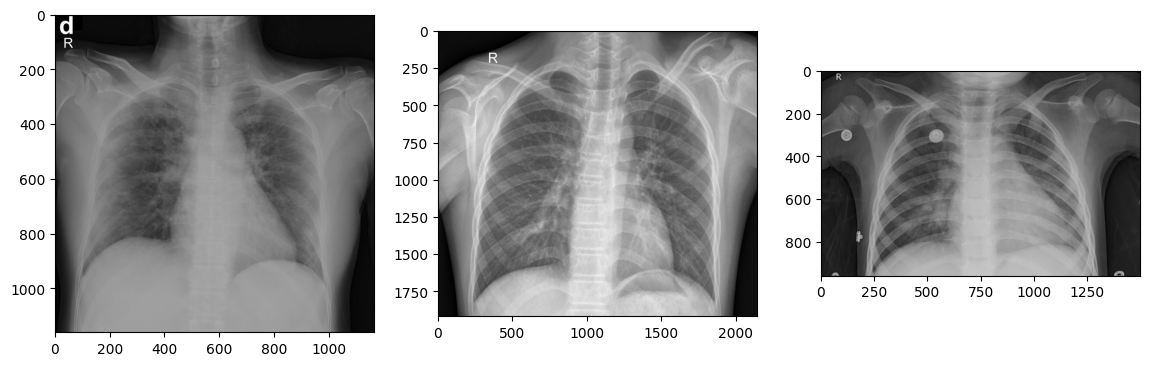

In [50]:
# Load and preview raw images
raw_img_covid     = cv.imread(raw_path + 'COVID-19/1-s2.0-S0929664620300449-gr2_lrg-d.jpg', 0)
raw_img_normal    = cv.imread(raw_path + 'Normal/IM-0011-0001-0001.jpeg', 0)
raw_img_pneumonia = cv.imread(raw_path + 'Pneumonia/person11_virus_38.jpeg', 0)

plt.figure(figsize=(14,14))
plt.subplot(1,3,1)
plt.imshow(raw_img_covid,cmap='gray')
plt.subplot(1,3,2)
plt.imshow(raw_img_normal,cmap='gray')
plt.subplot(1,3,3)
plt.imshow(raw_img_pneumonia,cmap='gray')

### View Cleaned Images
This section provides a side-by-side view of cleaned images to compare the effectiveness of the Roboflow cleaning process.

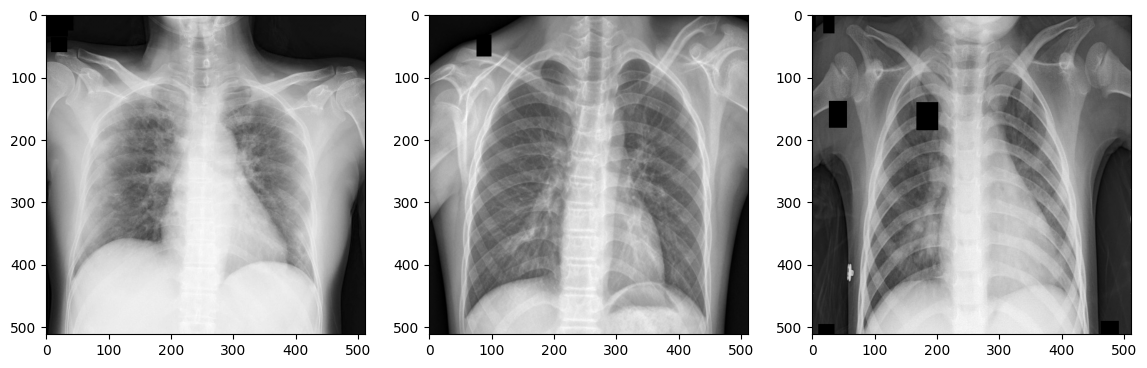

In [51]:

# Load and preview raw images
clean_img_covid     = cv.imread(clean_path + 'COVID-19/1-s2.0-S0929664620300449-gr2_lrg-d.jpg', 0)
clean_img_normal    = cv.imread(clean_path + 'Normal/IM-0011-0001-0001.jpeg', 0)
clean_img_pneumonia = cv.imread(clean_path + 'Pneumonia/person11_virus_38.jpeg', 0)

plt.figure(figsize=(14,14))
plt.subplot(2,3,1)
plt.imshow(clean_img_covid,cmap='gray')
plt.subplot(2,3,2)
plt.imshow(clean_img_normal,cmap='gray')
plt.subplot(2,3,3)
plt.imshow(clean_img_pneumonia,cmap='gray')

# Images and Their Corresponding Labels
We load all cleaned images, assign them class labels based on their directory, and return the images along with metadata. This is crucial for downstream machine learning tasks.

In [52]:
def load_chest_xray_data(data_dir):
    """
    Load chest X-ray images from a directory with subfolders for each class.
    
    Parameters:
    -----------
    data_dir : str
        Path to the main directory containing subfolders with images
    
    Returns:
    --------
    images : list
        List of image arrays
    labels : list
        List of corresponding labels
    label_map : dict
        Dictionary mapping label indices to label names
    image_paths : list
        List of image file paths
    """
    # Get all subdirectories (class labels)
    subfolders = [f for f in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, f))]
    
    # Create a label mapping
    label_map = {i: label for i, label in enumerate(subfolders)}
    
    images = []
    labels = []
    image_paths = []
    
    print(f"Found {len(subfolders)} classes: {subfolders}")
    
    # Loop through each subfolder (class)
    for label_idx, subfolder in enumerate(subfolders):
        class_dir = os.path.join(data_dir, subfolder)
        print(f"Loading images from {subfolder}...")
        
        # Get all image files
        img_paths = []
        for ext in ['*.png', '*.jpg', '*.jpeg']:
            img_paths.extend(glob(os.path.join(class_dir, ext)))
        
        # Load each image
        for img_path in img_paths:
            try:
                # Read image and convert to grayscale
                img = io.imread(img_path)
                if len(img.shape) > 2:  # Check if the image has more than 2 dimensions
                    img = np.mean(img, axis=2).astype(np.uint8)  # Convert to grayscale
                
                images.append(img)
                labels.append(label_idx)
                image_paths.append(img_path)
                
            except Exception as e:
                print(f"Error loading {img_path}: {e}")
        
        print(f"Loaded {len(img_paths)} images from {subfolder}")
    
    print(f"Total loaded: {len(images)} images")
    
    return images, labels, label_map, image_paths

In [53]:
images, labels, label_map, image_paths = load_chest_xray_data(clean_path)

Found 3 classes: ['COVID-19', 'Normal', 'Pneumonia']
Loading images from COVID-19...
Loaded 221 images from COVID-19
Loading images from Normal...
Loaded 234 images from Normal
Loading images from Pneumonia...
Loaded 148 images from Pneumonia
Total loaded: 603 images


Function for getting the analytics output for the model based on the mode, and test data.

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from IPython.display import display
import ipywidgets as widgets
import re

def get_model_analytics(model, x_test, y_test):
    """
    Evaluates a trained classification model on test data and prints:
    - Per-class and macro-average ROC-AUC scores
    - Classification report (precision, recall, F1-score)
    - Confusion matrix plot

    Parameters:
    -----------
    model : scikit-learn estimator
        Trained classification model (must support predict and optionally predict_proba)

    x_test : array-like
        Test feature data

    y_test : array-like
        True labels for the test data

    Returns:
    --------
    None
    Displays metrics and plots to stdout.
    """
    # Make predictions
    y_pred = model.predict(X=x_test)
    
    # For SVM, ensure 'probability=True' to get predict_proba
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X=x_test)
    else:
        # If no predict_proba, use decision function (for SVM)
        y_prob = model.decision_function(X=x_test)
        # For multi-class classification, we need to convert decision_function to probabilities
        encoder = OneHotEncoder()
        y_prob = encoder.fit_transform(y_prob.reshape(-1, 1)).toarray()

    # Split model class name and print all caps for section title
    if model.__class__.__name__ == "SVC":
        print(f"{model.__class__.__name__} MODEL ANALYTICS")
        print("-" * 50)
    else:
        model_name = re.split(r'(?=[A-Z])', model.__class__.__name__)
        model_name = ' '.join(filter(None, model_name))
        print(f"{model_name.upper()} MODEL ANALYTICS")
        print("-" * 50)

    # Print per-class AUC scores
    print(f"ROC-AUC Scores with OVR:\n{'ROC-AUC':>23}\n")
    for cls, score in zip(list(label_map.values()),
                          roc_auc_score(y_true=y_test, 
                                        y_score=y_prob, 
                                        multi_class='ovr', 
                                        average=None)):
        print(f"{cls:>12} {score:>10.4f}")

    # Print macro average AUC
    macro_auc = roc_auc_score(y_true=y_test, 
                          y_score=y_prob, 
                          multi_class='ovr', 
                          average='macro')
    print(f"\n{'macro avg':>12} {macro_auc:>10.4f}")

    # classification report
    print("\n\nClassification Report:")
    print(classification_report(y_true=y_test,
                                y_pred=y_pred,
                                target_names=list(label_map.values()),
                                digits=4))
        
    # Confustion matrix
    ConfusionMatrixDisplay.from_predictions(y_true=y_test,
                                            y_pred=y_pred,
                                            display_labels=label_map.values(),
                                            cmap=plt.cm.Blues,
                                            colorbar=False)
    plt.title("Confusion Matrix")
    plt.show()

def run_model_analytics_in_column(model, x_test, y_test, col_list):
    """
    Runs get_model_analytics() for a model and stores output in a widget container.

    Parameters:
    -----------
    model : sklearn estimator
        Trained classification model.

    x_test : ndarray
        Test feature data.

    y_test : ndarray
        Test labels.

    col_list : list
        List to append output widget to (for later display).
    """
    out = widgets.Output()
    with out:
        get_model_analytics(model, x_test, y_test)
    col_list.append(out)

def show_model_analytics_columns(col_list, columns_per_row=4, border_style="1px solid black", border_radius="8px", padding="10px"):
    """
    Displays a grid of model evaluation outputs using ipywidgets in rows and columns.

    Parameters:
    -----------
    col_list : list
        List of ipywidgets.Output objects.

    columns_per_row : int
        Number of models to display per row.

    border_style : str
        CSS styling for each model box border.

    border_radius : str
        CSS border radius.

    padding : str
        CSS padding inside each model box.
    """
    rows = []
    for i in range(0, len(col_list), columns_per_row):
        children = []
        for out in col_list[i:i+columns_per_row]:
            # Each output wrapped in a Box with a border
            child = widgets.Box(
                [out],
                layout=widgets.Layout(
                    border=border_style,
                    border_radius=border_radius,
                    padding=padding,
                    margin=f"10px 10px",  # spacing between columns
                    width='100%',  # Let it stretch inside the row
                )
            )
            children.append(child)
        row = widgets.HBox(children, layout=widgets.Layout(align_items='flex-start'))
        rows.append(row)
    display(widgets.VBox(rows))

def show_feature_importance(model, feature_importances, feature_inidicies, feature_names):
    """
    Plots a horizontal bar chart of permutation feature importance for a given model.

    Parameters:
    -----------
    model : sklearn estimator
        The trained model used for evaluation (used in the title).

    feature_importances : array-like
        Importance scores returned from permutation_importance.

    feature_inidicies : list of int
        Indices of features sorted by importance.

    feature_names : list of str
        Names of features (corresponding to DataFrame column names).
    """
    # Plot ALL features
    plt.figure(figsize=(20, 12))  # Larger figure for 48 features
    plt.title(f"{model.__class__.__name__} GLCM Feature Importance (Permutation Method)", fontsize=16)
    plt.bar(range(len(feature_importances)), feature_importances[feature_inidicies], align="center")
    plt.xticks(range(len(feature_importances)), [feature_names[i] for i in feature_inidicies], rotation=90, fontsize=10)
    plt.xlabel("Features", fontsize=14)
    plt.ylabel("Importance", fontsize=14)
    plt.tight_layout()
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Flattened Images Section
Images are flattened into 1D arrays to serve as features for machine learning models. Labels are preserved, and a train-test split is applied. Feature scaling is done using StandardScaler.

In [55]:
df = pd.DataFrame({
    "image": [img.flatten() for img in images],
    "label": labels})

X_train_flat, X_test_flat, y_train_flat, y_test_flat = train_test_split(
    np.array(df["image"].tolist()), 
    df["label"], 
    test_size=0.2, 
    stratify=labels, 
    random_state=RANDOM_STATE)

X_train_flat = StandardScaler().fit_transform(X_train_flat)
X_test_flat = StandardScaler().fit_transform(X_test_flat)

Summary statistics of flattened image data

In [56]:
# Create a DataFrame with per-image stats
flat_summary_df = pd.DataFrame({
    "label": pd.Series(labels).map(label_map),
    "mean_pixel": [np.mean(img) for img in df["image"]],
    "std_pixel": [np.std(img) for img in df["image"]],
    "min_pixel": [np.min(img) for img in df["image"]],
    "max_pixel": [np.max(img) for img in df["image"]],
    "nonzero_pixels": [np.count_nonzero(img) for img in df["image"]]
})

# Group by label and calculate the mean of each stat
flat_summary_df.groupby("label").mean()

,mean_pixel,std_pixel,min_pixel,max_pixel,nonzero_pixels
label,,,,,
COVID-19,134.489708,55.123013,2.004525,234.248869,251150.457014
Normal,123.298157,60.228426,0.021368,240.384615,246386.106838
Pneumonia,122.062239,62.178421,0.000000,233.459459,240538.344595


# Perform Machine Learning Techniques on Flattened Images

### Logistic Regresssion on Flattened Images
We apply Logistic with hyperparameter tuning via GridSearchCV. The optimal model is evaluated with a classification report and confusion matrix.

Optimal Hyperparameters:
{'C': 0.01, 'max_iter': 100, 'tol': 0.0001}

Optimal F1-macro score:: 0.8816665834831356
LOGISTIC REGRESSION MODEL ANALYTICS
--------------------------------------------------
ROC-AUC Scores with OVR:
                ROC-AUC

    COVID-19     0.9950
      Normal     0.9560
   Pneumonia     0.9689

   macro avg     0.9733


Classification Report:
              precision    recall  f1-score   support

    COVID-19     0.9535    0.9318    0.9425        44
      Normal     0.8667    0.8298    0.8478        47
   Pneumonia     0.8182    0.9000    0.8571        30

    accuracy                         0.8843       121
   macro avg     0.8794    0.8872    0.8825       121
weighted avg     0.8862    0.8843    0.8846       121



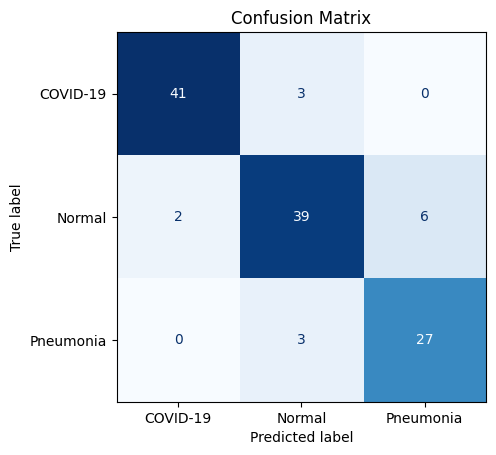

In [57]:
from sklearn.linear_model import LogisticRegression

lr_flat = LogisticRegression(solver='lbfgs', 
                             class_weight='balanced',
                             random_state=RANDOM_STATE)

param_grid = {
    'C': [0.01, 0.1, 1, 10, 100, 1000],
    'max_iter': [100, 500, 1000, 2000],
    'tol': [1e-4, 1e-3, 1e-2]
}

grid_search = GridSearchCV(
    lr_flat,
    param_grid=param_grid,
    scoring='f1_macro',
    cv=5,
    n_jobs=-1, 
    verbose=0 
)

grid_search.fit(X_train_flat, y_train_flat)

print("Optimal Hyperparameters:")
print(grid_search.best_params_)

print(f"\nOptimal F1-macro score:: {grid_search.best_score_}")

# Set best estimator as model
lr_flat = grid_search.best_estimator_

# Get Results from Model
get_model_analytics(lr_flat, X_test_flat, y_test_flat)

### Random Forest on Flattened Images
We apply a Random Forest classifier with hyperparameter tuning via GridSearchCV. The optimal model is evaluated with a classification report and confusion matrix.

Optimal Hyperparameters:
{'max_depth': 7, 'max_features': 'log2', 'n_estimators': 134}

Optimal F1-macro score:: 0.8775981623469231
RANDOM FOREST CLASSIFIER MODEL ANALYTICS
--------------------------------------------------
ROC-AUC Scores with OVR:
                ROC-AUC

    COVID-19     0.9947
      Normal     0.9517
   Pneumonia     0.9538

   macro avg     0.9667


Classification Report:
              precision    recall  f1-score   support

    COVID-19     0.9756    0.9091    0.9412        44
      Normal     0.8367    0.8723    0.8542        47
   Pneumonia     0.7742    0.8000    0.7869        30

    accuracy                         0.8678       121
   macro avg     0.8622    0.8605    0.8607       121
weighted avg     0.8717    0.8678    0.8691       121



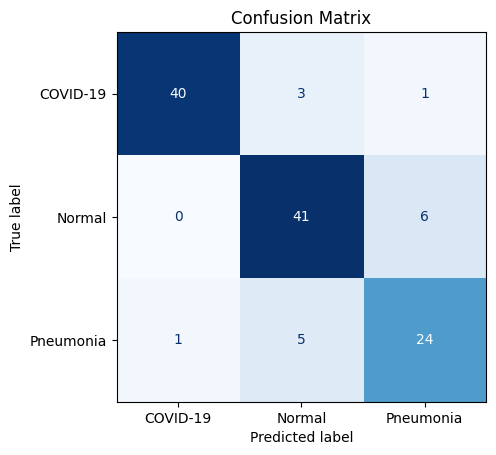

In [58]:
from sklearn.ensemble import RandomForestClassifier

rf_flat = RandomForestClassifier(class_weight='balanced', 
                                 random_state=RANDOM_STATE)

param_grid = {
    'max_depth': range(5, 51, 2),
    'max_features': ['sqrt', 'log2'],
    'n_estimators': range(50, 151, 2)
}

grid_search = GridSearchCV(
    rf_flat,
    param_grid=param_grid,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=0)

grid_search.fit(X_train_flat, y_train_flat)

print("Optimal Hyperparameters:")
print(grid_search.best_params_)

print(f"\nOptimal F1-macro score:: {grid_search.best_score_}")

# Set best estimator as model
rf_flat = grid_search.best_estimator_

# Get Results from Model
get_model_analytics(rf_flat, X_test_flat, y_test_flat)

### SVC on Flattened Images
An SVC classifier is trained with different kernels and hyperparameters to find the best fit for the flattened image data.

Optimal Hyperparameters:
{'C': 0.1, 'gamma': 1, 'kernel': 'linear'}

Optimal F1-macro score: 0.878092466903375
SVC MODEL ANALYTICS
--------------------------------------------------
ROC-AUC Scores with OVR:
                ROC-AUC

    COVID-19     0.9944
      Normal     0.9638
   Pneumonia     0.9659

   macro avg     0.9747


Classification Report:
              precision    recall  f1-score   support

    COVID-19     0.9333    0.9545    0.9438        44
      Normal     0.8837    0.8085    0.8444        47
   Pneumonia     0.7879    0.8667    0.8254        30

    accuracy                         0.8760       121
   macro avg     0.8683    0.8766    0.8712       121
weighted avg     0.8780    0.8760    0.8759       121



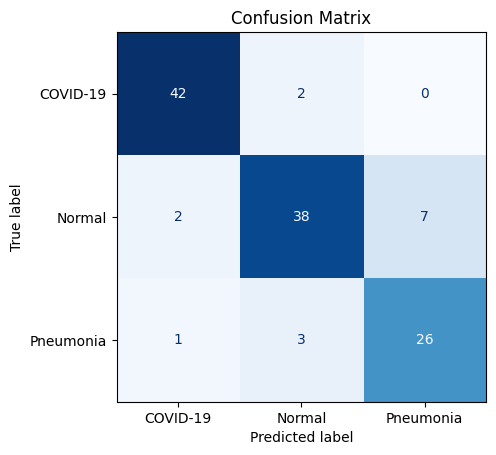

In [59]:
from sklearn.svm import SVC

svc_flat = SVC(probability=True, 
               class_weight='balanced',
               random_state=RANDOM_STATE)

param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['linear', 'rbf']}

grid_search = GridSearchCV(
    svc_flat,
    param_grid=param_grid,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=0)

grid_search.fit(X_train_flat, y_train_flat)

print("Optimal Hyperparameters:")
print(grid_search.best_params_)

print(f"\nOptimal F1-macro score: {grid_search.best_score_}")

# Set best estimator as model
svc_flat = grid_search.best_estimator_

# Get Results from Model
get_model_analytics(svc_flat, X_test_flat, y_test_flat)

### k-Nearest Neighbors on Flattened Images
We test the performance of a k-NN classifier by tuning the number of neighbors using grid search.

Optimal Hyperparameters:
{'n_neighbors': 12}

Optimal F1-macro score:: 0.819094607629761
K NEIGHBORS CLASSIFIER MODEL ANALYTICS
--------------------------------------------------
ROC-AUC Scores with OVR:
                ROC-AUC

    COVID-19     0.9951
      Normal     0.9130
   Pneumonia     0.9366

   macro avg     0.9483


Classification Report:
              precision    recall  f1-score   support

    COVID-19     0.9750    0.8864    0.9286        44
      Normal     0.7805    0.6809    0.7273        47
   Pneumonia     0.6250    0.8333    0.7143        30

    accuracy                         0.7934       121
   macro avg     0.7935    0.8002    0.7900       121
weighted avg     0.8127    0.7934    0.7973       121



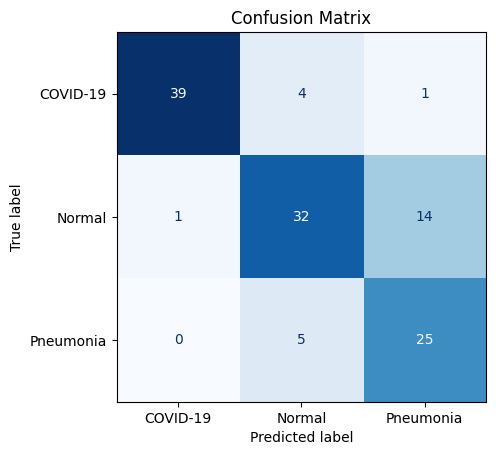

In [60]:
from sklearn.neighbors import KNeighborsClassifier

knn_flat = KNeighborsClassifier()

param_grid = {'n_neighbors': range(1, 40)}

grid_search = GridSearchCV(
    knn_flat,
    param_grid=param_grid,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=0)

grid_search.fit(X_train_flat, y_train_flat)

print("Optimal Hyperparameters:")
print(grid_search.best_params_)

print(f"\nOptimal F1-macro score:: {grid_search.best_score_}")

# Set best estimator as model
knn_flat = grid_search.best_estimator_

# Get Results from Model
get_model_analytics(knn_flat, X_test_flat, y_test_flat)

# GLCM Section
## Texture-Based Feature Extraction
We extract GLCM (Gray-Level Co-occurrence Matrix) features from each image, which are effective for texture analysis in medical images. Features include contrast, energy, and correlation at multiple distances and angles.

In [ ]:
def extract_glcm_features_df(images,
                            labels,
                            image_paths, 
                            target_size=(512, 512), 
                            distances=[1, 2, 3], 
                            angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],
                            g_levels=256):
    """
    Extracts Gray-Level Co-occurrence Matrix (GLCM) texture features from a list of images and
    returns them as a DataFrame.

    Parameters:
    -----------
    images : list of ndarray
        List of grayscale image arrays.

    labels : list of int
        Class labels for each image.

    image_paths : list of str
        List of image paths (used to derive image IDs).

    target_size : tuple of int, default=(512, 512)
        Size to resize images before GLCM extraction.

    distances : list of int
        Distances between pixel pairs for GLCM calculation.

    angles : list of float
        Angles (in radians) for GLCM calculation.

    g_levels : int, default=256
        Number of grayscale levels (quantization) for texture extraction.

    Returns:
    --------
    glcm : ndarray
        Raw GLCM matrices for all images.

    df : pandas.DataFrame
        Table containing image IDs, labels, and 36 extracted GLCM features per image.
    """
    # GLCM properties to calculate
    properties = ['contrast', 'energy', 'correlation']
    
    # Create feature labels
    feature_labels = []
    for prop in properties:
        for d in distances:
            for a in angles:
                angle_deg = int(a * 180 / np.pi)  # Convert angle to degrees
                feature_labels.append(f"{prop}_d{d}_a{angle_deg}")
    
    # Initialize feature array
    n_features = len(properties) * len(distances) * len(angles)
    features = np.zeros((len(images), n_features))
    
    # Create image IDs from paths (get filename without extension)
    if isinstance(image_paths[0], str):
        image_ids = [os.path.splitext(os.path.basename(path))[0] for path in image_paths]
    else:
        # If not paths, use as is
        image_ids = image_paths
    
    # Extract GLCM features for each image
    for i, img in enumerate(images):
        if i % 100 == 0:
            print(f"Processing image {i}/{len(images)}")
        
        # Resize image to ensure consistency
        img_resized = resize(img, target_size, anti_aliasing=True, preserve_range=True).astype(np.uint8)
        
        # Rescale the image to have values between 0 and (levels-1)
        levels = g_levels
        # Normalization: Min-max scaling to range [0, levels-1]
        img_scaled = ((img_resized - img_resized.min()) / (img_resized.max() - img_resized.min() + 1e-10) * (levels-1)).astype(np.uint8)
        
        # Calculate GLCM
        glcm = graycomatrix(img_scaled, distances=distances, angles=angles, 
                           levels=levels, symmetric=True, normed=True)
        
        # Calculate GLCM properties
        feature_idx = 0
        for prop in properties:
            glcm_prop = graycoprops(glcm, prop)
            for d in range(len(distances)):
                for a in range(len(angles)):
                    features[i, feature_idx] = glcm_prop[d, a]
                    feature_idx += 1
    
    # Create the DataFrame
    data = {
        'image_id': image_ids,
        'label': labels
    }
    
    # Add each feature as a column
    for i, feature_name in enumerate(feature_labels):
        data[feature_name] = features[:, i]
    
    # Create the DataFrame
    df = pd.DataFrame(data)
    
    return glcm, df

In [62]:
glcm, glcm_df = extract_glcm_features_df(
    images, 
    labels, 
    image_paths, 
    target_size=(512, 512),
    distances=[1, 5, 10],
    angles=[0, np.pi/4, np.pi/2, 3*np.pi/4]
)

Processing image 0/603
Processing image 100/603
Processing image 200/603
Processing image 300/603
Processing image 400/603
Processing image 500/603
Processing image 600/603


### Train-Test Split on GLCM Data
We split the extracted GLCM features into training and testing sets for model evaluation.

In [63]:
X_train_glcm, X_test_glcm, y_train_glcm, y_test_glcm = train_test_split(
    glcm_df.drop(columns=['image_id', 'label'], axis=1),
    glcm_df['label'],
    test_size=0.3,
    random_state=RANDOM_STATE,
    stratify=glcm_df['label']
)

X_train_glcm = StandardScaler().fit_transform(X_train_glcm)
X_test_glcm = StandardScaler().fit_transform(X_test_glcm)

Summary statistics of GLCM data broken down in groupings by property type, and distances.

In [64]:
glcm_summary_df = glcm_df.drop(columns=['image_id']).copy()
glcm_summary_df['label'] = pd.Series(glcm_summary_df['label']).map(label_map)
grouped_stats = glcm_summary_df.groupby('label').agg(['mean', 'std', 'min', 'max'])

distances = ['1', '5', '10']
properties = ['contrast', 'energy', 'correlation']
for prop in properties:
    for dist in distances:
        display(grouped_stats.filter(regex=fr'{prop}_d{dist}(?!\d)', axis=1))

contrast_d1_a0                                   contrast_d1_a45  \
                    mean        std        min         max            mean   
label                                                                        
COVID-19       32.591725  27.696591   3.542694  194.315367       61.084996   
Normal         35.166668  11.317371  19.095072   97.985002       49.294792   
Pneumonia      32.228109   9.189350  13.365315   64.773178       47.929479   

                                            contrast_d1_a90             \
                 std        min         max            mean        std   
label                                                                    
COVID-19   43.111253   8.145680  263.443767       33.293328  25.992421   
Normal     14.132794  27.560924  112.948959       19.616468   5.990792   
Pneumonia  15.096364  18.302055  114.542771       24.417580   7.781984   

                                 contrast_d1_a135                        \
                 min         max             mean        std        min   
label                                                                     
COVID-19    5.079600  150.478867        61.421794  43.385297   8.993693   
Normal     10.113212   70.127607        50.164819  14.346129  29.028718   
Pneumonia  10.690768   64.250990        48.344166  15.156328  21.622807   

                       
                  max  
label                  
COVID-19   269.746830  
Normal     125.368580  
Pneumonia  124.727153

contrast_d5_a0                                      contrast_d5_a45  \
                    mean         std         min          max            mean   
label                                                                           
COVID-19      226.065195  172.254126   37.035133  1458.844104      284.409001   
Normal        340.657678   94.051630  181.481813   814.849359      318.925021   
Pneumonia     265.344164   74.755588  132.408438   522.568714      251.362638   

                                               contrast_d5_a90              \
                  std         min          max            mean         std   
label                                                                        
COVID-19   189.280405   48.410297  1401.501093      207.983388  141.785451   
Normal      87.206926  171.322203   706.580515      176.978856   49.038679   
Pneumonia   80.975570  110.338916   566.573846      144.546871   55.599319   

                                 contrast_d5_a135                          \
                 min         max             mean         std         min   
label                                                                       
COVID-19   41.087151  844.656308       287.901344  192.473418   43.547167   
Normal     80.568960  553.829997       324.725584   87.943199  176.936779   
Pneumonia  57.019450  406.056521       255.842747   82.922935  130.279861   

                        
                   max  
label                   
COVID-19   1401.131123  
Normal      772.615855  
Pneumonia   627.299011

contrast_d10_a0                                       \
                     mean         std         min          max   
label                                                            
COVID-19       493.698915  323.861884   82.945149  2788.861476   
Normal         819.322604  196.980606  446.304991  1798.999790   
Pneumonia      655.139833  175.027055  311.859772  1208.941690   

          contrast_d10_a45                                       \
                      mean         std         min          max   
label                                                             
COVID-19        502.986292  310.567629   94.422308  2471.241576   
Normal          626.732393  160.456095  342.533116  1346.313593   
Pneumonia       493.224769  150.825383  236.383217  1030.981178   

          contrast_d10_a90                                       \
                      mean         std         min          max   
label                                                             
COVID-19        404.686296  263.169336   86.561753  1760.324176   
Normal          380.124537  102.463280  175.599858  1201.151892   
Pneumonia       301.220412  115.126666  117.824728   765.656223   

          contrast_d10_a135                                       
                       mean         std         min          max  
label                                                             
COVID-19         511.738961  315.660814   84.510197  2430.311150  
Normal           636.172965  159.556356  356.154753  1350.112848  
Pneumonia        502.131490  153.536661  238.975465  1118.603560

energy_d1_a0                               energy_d1_a45            \
                  mean       std       min       max          mean       std   
label                                                                          
COVID-19      0.068914  0.064633  0.019212  0.506081      0.065688  0.064758   
Normal        0.067460  0.037503  0.019589  0.205913      0.066257  0.038041   
Pneumonia     0.086379  0.045566  0.019642  0.238570      0.085202  0.046174   

                              energy_d1_a90                                \
                min       max          mean       std       min       max   
label                                                                       
COVID-19   0.018553  0.501600      0.070440  0.064595  0.020642  0.504980   
Normal     0.017337  0.201739      0.071143  0.037735  0.020959  0.205716   
Pneumonia  0.018079  0.238458      0.089699  0.045375  0.021768  0.242039   

          energy_d1_a135                                
                    mean       std       min       max  
label                                                   
COVID-19        0.065675  0.064771  0.018627  0.501955  
Normal          0.066242  0.038044  0.017416  0.201797  
Pneumonia       0.085156  0.046183  0.018065  0.238501

energy_d5_a0                               energy_d5_a45            \
                  mean       std       min       max          mean       std   
label                                                                          
COVID-19      0.057259  0.063956  0.013674  0.495696      0.055611  0.063363   
Normal        0.054156  0.036011  0.011339  0.191221      0.055991  0.036884   
Pneumonia     0.073495  0.045002  0.012086  0.225700      0.075007  0.045905   

                              energy_d5_a90                                \
                min       max          mean       std       min       max   
label                                                                       
COVID-19   0.013393  0.489034      0.058927  0.064778  0.014839  0.494256   
Normal     0.010899  0.183307      0.065313  0.039869  0.012546  0.192946   
Pneumonia  0.012075  0.228857      0.083507  0.047690  0.015311  0.239860   

          energy_d5_a135                                
                    mean       std       min       max  
label                                                   
COVID-19        0.055660  0.063371  0.013347  0.489664  
Normal          0.055955  0.036890  0.011018  0.183399  
Pneumonia       0.074923  0.045850  0.012045  0.229221

energy_d10_a0                               energy_d10_a45  \
                   mean       std       min       max           mean   
label                                                                  
COVID-19       0.051302  0.061072  0.011199  0.483584       0.050134   
Normal         0.042353  0.031588  0.009054  0.173381       0.048191   
Pneumonia      0.061052  0.041234  0.009934  0.208364       0.066853   

                                        energy_d10_a90                      \
                std       min       max           mean       std       min   
label                                                                        
COVID-19   0.060806  0.011402  0.474258       0.053396  0.063205  0.011855   
Normal     0.034277  0.008980  0.163078       0.063084  0.040242  0.010262   
Pneumonia  0.044090  0.010267  0.218884       0.080198  0.048222  0.013274   

                    energy_d10_a135                                
                max            mean       std       min       max  
label                                                              
COVID-19   0.478505        0.050216  0.060792  0.011311  0.475381  
Normal     0.185239        0.048144  0.034287  0.009141  0.163220  
Pneumonia  0.238215        0.066750  0.043958  0.010221  0.219497

correlation_d1_a0                               correlation_d1_a45  \
                       mean       std       min       max               mean   
label                                                                          
COVID-19           0.995138  0.004984  0.952597  0.999572           0.990921   
Normal             0.995574  0.001526  0.988300  0.998110           0.993784   
Pneumonia          0.996291  0.001622  0.986340  0.998747           0.994496   

                                        correlation_d1_a90            \
                std       min       max               mean       std   
label                                                                  
COVID-19   0.007494  0.934702  0.999026           0.995027  0.004683   
Normal     0.001979  0.985968  0.997129           0.997509  0.000908   
Pneumonia  0.002378  0.982009  0.997977           0.997223  0.001143   

                              correlation_d1_a135                      \
                min       max                mean       std       min   
label                                                                   
COVID-19   0.957428  0.999466            0.990880  0.007519  0.935495   
Normal     0.993242  0.999009            0.993669  0.002039  0.985483   
Pneumonia  0.991516  0.999108            0.994452  0.002417  0.980915   

                     
                max  
label                
COVID-19   0.998909  
Normal     0.997072  
Pneumonia  0.997938

correlation_d5_a0                              correlation_d5_a45  \
                       mean       std       min      max               mean   
label                                                                         
COVID-19           0.967857  0.021935  0.819712  0.99471           0.958914   
Normal             0.956436  0.012841  0.912207  0.97928           0.959253   
Pneumonia          0.969391  0.011359  0.919452  0.98608           0.970976   

                                        correlation_d5_a90            \
                std       min       max               mean       std   
label                                                                  
COVID-19   0.025690  0.840355  0.991914           0.969775  0.019835   
Normal     0.011831  0.921942  0.980590           0.977493  0.007603   
Pneumonia  0.011781  0.919885  0.988644           0.983495  0.007797   

                              correlation_d5_a135                      \
                min       max                mean       std       min   
label                                                                   
COVID-19   0.877972  0.993914            0.958480  0.026060  0.821413   
Normal     0.951125  0.990555            0.958478  0.012160  0.917356   
Pneumonia  0.948414  0.995122            0.970527  0.011942  0.918959   

                     
                max  
label                
COVID-19   0.991533  
Normal     0.980561  
Pneumonia  0.988231

correlation_d10_a0                                \
                        mean       std       min       max   
label                                                        
COVID-19            0.930238  0.038944  0.671725  0.984433   
Normal              0.893035  0.027292  0.799125  0.950495   
Pneumonia           0.923543  0.023624  0.834057  0.960744   

          correlation_d10_a45                                \
                         mean       std       min       max   
label                                                         
COVID-19             0.927389  0.039469  0.729820  0.983404   
Normal               0.918721  0.021804  0.849886  0.959071   
Pneumonia            0.942594  0.020864  0.873195  0.975605   

          correlation_d10_a90                                \
                         mean       std       min       max   
label                                                         
COVID-19             0.941252  0.034339  0.756874  0.986745   
Normal               0.951544  0.015514  0.902259  0.980926   
Pneumonia            0.965673  0.015639  0.905718  0.989908   

          correlation_d10_a135                                
                          mean       std       min       max  
label                                                         
COVID-19              0.926255  0.040081  0.703662  0.982648  
Normal                0.917419  0.022268  0.843708  0.959392  
Pneumonia             0.941740  0.020857  0.869318  0.974118

## Perform Machine Learning Techniques on GLCM Data

### Logistic Regression on GLCM Features
Logistic regression is applied with lbfgs solver to classify the GLCM features.

LOGISTIC REGRESSION MODEL ANALYTICS
--------------------------------------------------
ROC-AUC Scores with OVR:
                ROC-AUC

    COVID-19     0.9628
      Normal     0.9273
   Pneumonia     0.9616

   macro avg     0.9506


Classification Report:
              precision    recall  f1-score   support

    COVID-19     0.9355    0.8788    0.9062        66
      Normal     0.8788    0.8286    0.8529        70
   Pneumonia     0.7736    0.9111    0.8367        45

    accuracy                         0.8674       181
   macro avg     0.8626    0.8728    0.8653       181
weighted avg     0.8733    0.8674    0.8684       181



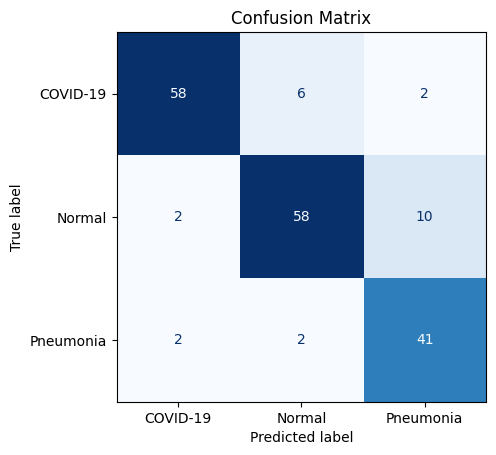

In [65]:
from sklearn.linear_model import LogisticRegression

lr_glcm = LogisticRegression(solver='lbfgs', 
                             class_weight='balanced',
                             random_state=RANDOM_STATE)

# Train the classifier
lr_glcm.fit(X_train_glcm, y_train_glcm)
# Get Results from Model
get_model_analytics(lr_glcm, X_test_glcm, y_test_glcm)

Optimal Hyperparameters:
{'C': 1000, 'max_iter': 500, 'tol': 0.0001}

Optimal F1-macro score: 0.8648058827319598
LOGISTIC REGRESSION MODEL ANALYTICS
--------------------------------------------------
ROC-AUC Scores with OVR:
                ROC-AUC

    COVID-19     0.9718
      Normal     0.9369
   Pneumonia     0.9314

   macro avg     0.9467


Classification Report:
              precision    recall  f1-score   support

    COVID-19     0.9623    0.7727    0.8571        66
      Normal     0.8788    0.8286    0.8529        70
   Pneumonia     0.6452    0.8889    0.7477        45

    accuracy                         0.8232       181
   macro avg     0.8287    0.8301    0.8192       181
weighted avg     0.8511    0.8232    0.8283       181



lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


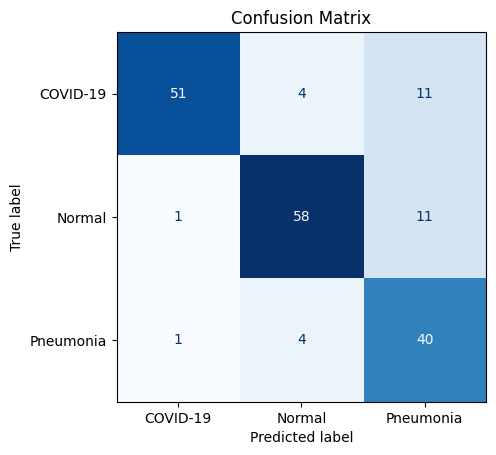

In [66]:
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100, 1000],
    'max_iter': [100, 500, 1000, 2000],
    'tol': [1e-4, 1e-3, 1e-2]
}

grid_search = GridSearchCV(
    lr_glcm, 
    param_grid=param_grid,
    cv=5, 
    scoring='f1_macro',
    n_jobs=-1
)

grid_search.fit(X_train_glcm, y_train_glcm)

print("Optimal Hyperparameters:")
print(grid_search.best_params_)

print(f"\nOptimal F1-macro score: {grid_search.best_score_}")

# Set best estimator as model
lr_glcm = grid_search.best_estimator_
# Get Results from Model
get_model_analytics(lr_glcm, X_test_glcm, y_test_glcm)

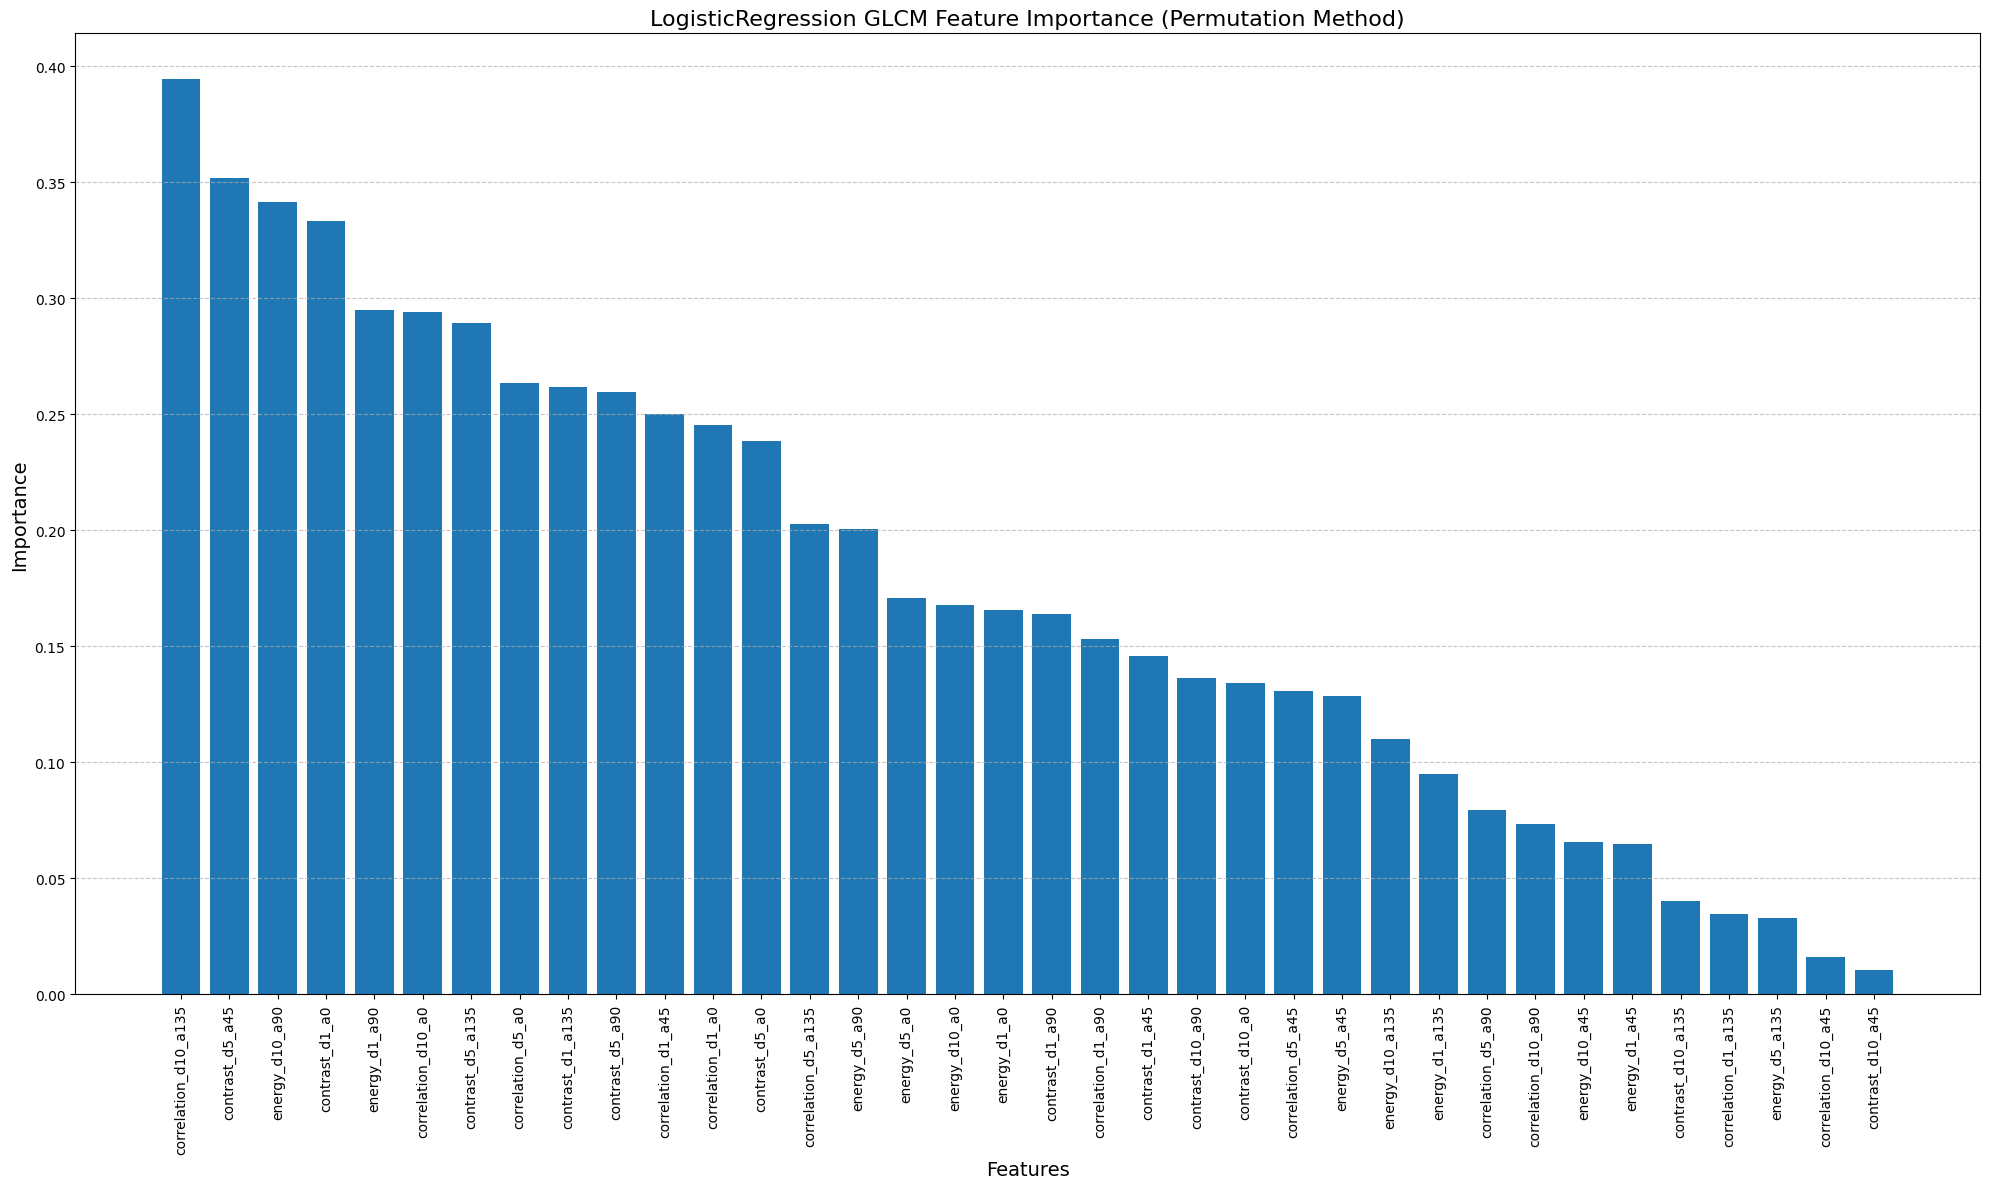

In [67]:
# permutation importance
result = permutation_importance(lr_glcm, X_test_glcm, y_test_glcm, n_repeats=10, random_state=RANDOM_STATE)
perm_importances = result.importances_mean

# Extract feature names from df
feature_names = glcm_df.drop(columns=['image_id', 'label']).columns.tolist()

# Sort features by importance
perm_indices = np.argsort(perm_importances)[::-1]

# plot feature importances 
show_feature_importance(lr_glcm, perm_importances, perm_indices, feature_names)

In [68]:
important_indices = [i for i, importance in enumerate(perm_importances) if importance > 0]
best_features = [feature_names[i] for i in important_indices]
print(f"Best features: {best_features}")

# slice to only positive features of X_train and X_test (y_train and y_test are uneffected)
X_train_glcm_lr = X_train_glcm[:, important_indices].copy()
X_test_glcm_lr = X_test_glcm[:, important_indices].copy()

Best features: ['contrast_d1_a0', 'contrast_d1_a45', 'contrast_d1_a90', 'contrast_d1_a135', 'contrast_d5_a0', 'contrast_d5_a45', 'contrast_d5_a90', 'contrast_d5_a135', 'contrast_d10_a0', 'contrast_d10_a45', 'contrast_d10_a90', 'contrast_d10_a135', 'energy_d1_a0', 'energy_d1_a45', 'energy_d1_a90', 'energy_d1_a135', 'energy_d5_a0', 'energy_d5_a45', 'energy_d5_a90', 'energy_d5_a135', 'energy_d10_a0', 'energy_d10_a45', 'energy_d10_a90', 'energy_d10_a135', 'correlation_d1_a0', 'correlation_d1_a45', 'correlation_d1_a90', 'correlation_d1_a135', 'correlation_d5_a0', 'correlation_d5_a45', 'correlation_d5_a90', 'correlation_d5_a135', 'correlation_d10_a0', 'correlation_d10_a45', 'correlation_d10_a90', 'correlation_d10_a135']


Optimal Hyperparameters:
{'C': 1000, 'max_iter': 500, 'tol': 0.0001}

Optimal F1-macro score: 0.8648058827319598
LOGISTIC REGRESSION MODEL ANALYTICS
--------------------------------------------------
ROC-AUC Scores with OVR:
                ROC-AUC

    COVID-19     0.9718
      Normal     0.9369
   Pneumonia     0.9314

   macro avg     0.9467


Classification Report:
              precision    recall  f1-score   support

    COVID-19     0.9623    0.7727    0.8571        66
      Normal     0.8788    0.8286    0.8529        70
   Pneumonia     0.6452    0.8889    0.7477        45

    accuracy                         0.8232       181
   macro avg     0.8287    0.8301    0.8192       181
weighted avg     0.8511    0.8232    0.8283       181



lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


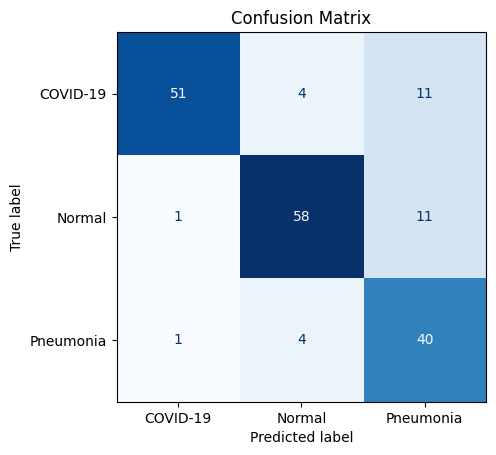

In [69]:
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100, 1000],
    'max_iter': [100, 500, 1000, 2000],
    'tol': [1e-4, 1e-3, 1e-2]
}

grid_search = GridSearchCV(
    lr_glcm, 
    param_grid=param_grid,
    cv=5, 
    scoring='f1_macro',
    n_jobs=-1
)

grid_search.fit(X_train_glcm_lr, y_train_glcm)

print("Optimal Hyperparameters:")
print(grid_search.best_params_)

print(f"\nOptimal F1-macro score: {grid_search.best_score_}")

# Set best estimator as model
lr_glcm_positive_only = grid_search.best_estimator_
# Get Results from Model
get_model_analytics(lr_glcm_positive_only, X_test_glcm_lr, y_test_glcm)

### Random Forest on GLCM Features
A Random Forest classifier is applied to the GLCM features, and performance is evaluated using classification metrics.

RANDOM FOREST CLASSIFIER MODEL ANALYTICS
--------------------------------------------------
ROC-AUC Scores with OVR:
                ROC-AUC

    COVID-19     0.9500
      Normal     0.9416
   Pneumonia     0.9480

   macro avg     0.9465


Classification Report:
              precision    recall  f1-score   support

    COVID-19     0.8261    0.8636    0.8444        66
      Normal     0.7922    0.8714    0.8299        70
   Pneumonia     0.8571    0.6667    0.7500        45

    accuracy                         0.8177       181
   macro avg     0.8251    0.8006    0.8081       181
weighted avg     0.8207    0.8177    0.8154       181



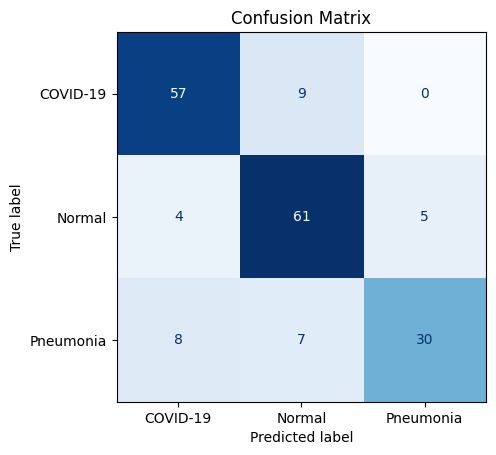

In [70]:
from sklearn.ensemble import RandomForestClassifier

rf_glcm = RandomForestClassifier(class_weight='balanced', 
                                 random_state=RANDOM_STATE)

# Train the classifier
rf_glcm.fit(X_train_glcm, y_train_glcm)
# Get Results from Model
get_model_analytics(rf_glcm, X_test_glcm, y_test_glcm)

Optimal Hyperparameters:
{'max_depth': 13, 'max_features': 'sqrt', 'n_estimators': 126}

Optimal F1-macro score: 0.8254959263509271
RANDOM FOREST CLASSIFIER MODEL ANALYTICS
--------------------------------------------------
ROC-AUC Scores with OVR:
                ROC-AUC

    COVID-19     0.9509
      Normal     0.9402
   Pneumonia     0.9454

   macro avg     0.9455


Classification Report:
              precision    recall  f1-score   support

    COVID-19     0.8154    0.8030    0.8092        66
      Normal     0.7564    0.8429    0.7973        70
   Pneumonia     0.7895    0.6667    0.7229        45

    accuracy                         0.7845       181
   macro avg     0.7871    0.7709    0.7764       181
weighted avg     0.7861    0.7845    0.7831       181



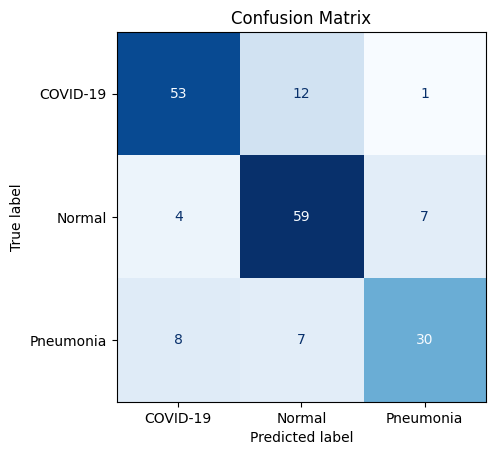

In [71]:
param_grid = {
    'max_depth': range(5, 101, 2),
    'max_features': ['sqrt', 'log2'],
    'n_estimators': range(50, 151, 2)
}

grid_search = GridSearchCV(
    rf_glcm, 
    param_grid=param_grid,
    cv=5, 
    scoring='f1_macro',
    n_jobs=-1
)

grid_search.fit(X_train_glcm, y_train_glcm)

print("Optimal Hyperparameters:")
print(grid_search.best_params_)

print(f"\nOptimal F1-macro score: {grid_search.best_score_}")

# Set best estimator as model
rf_glcm = grid_search.best_estimator_
# Get Results from Model
get_model_analytics(rf_glcm, X_test_glcm, y_test_glcm)

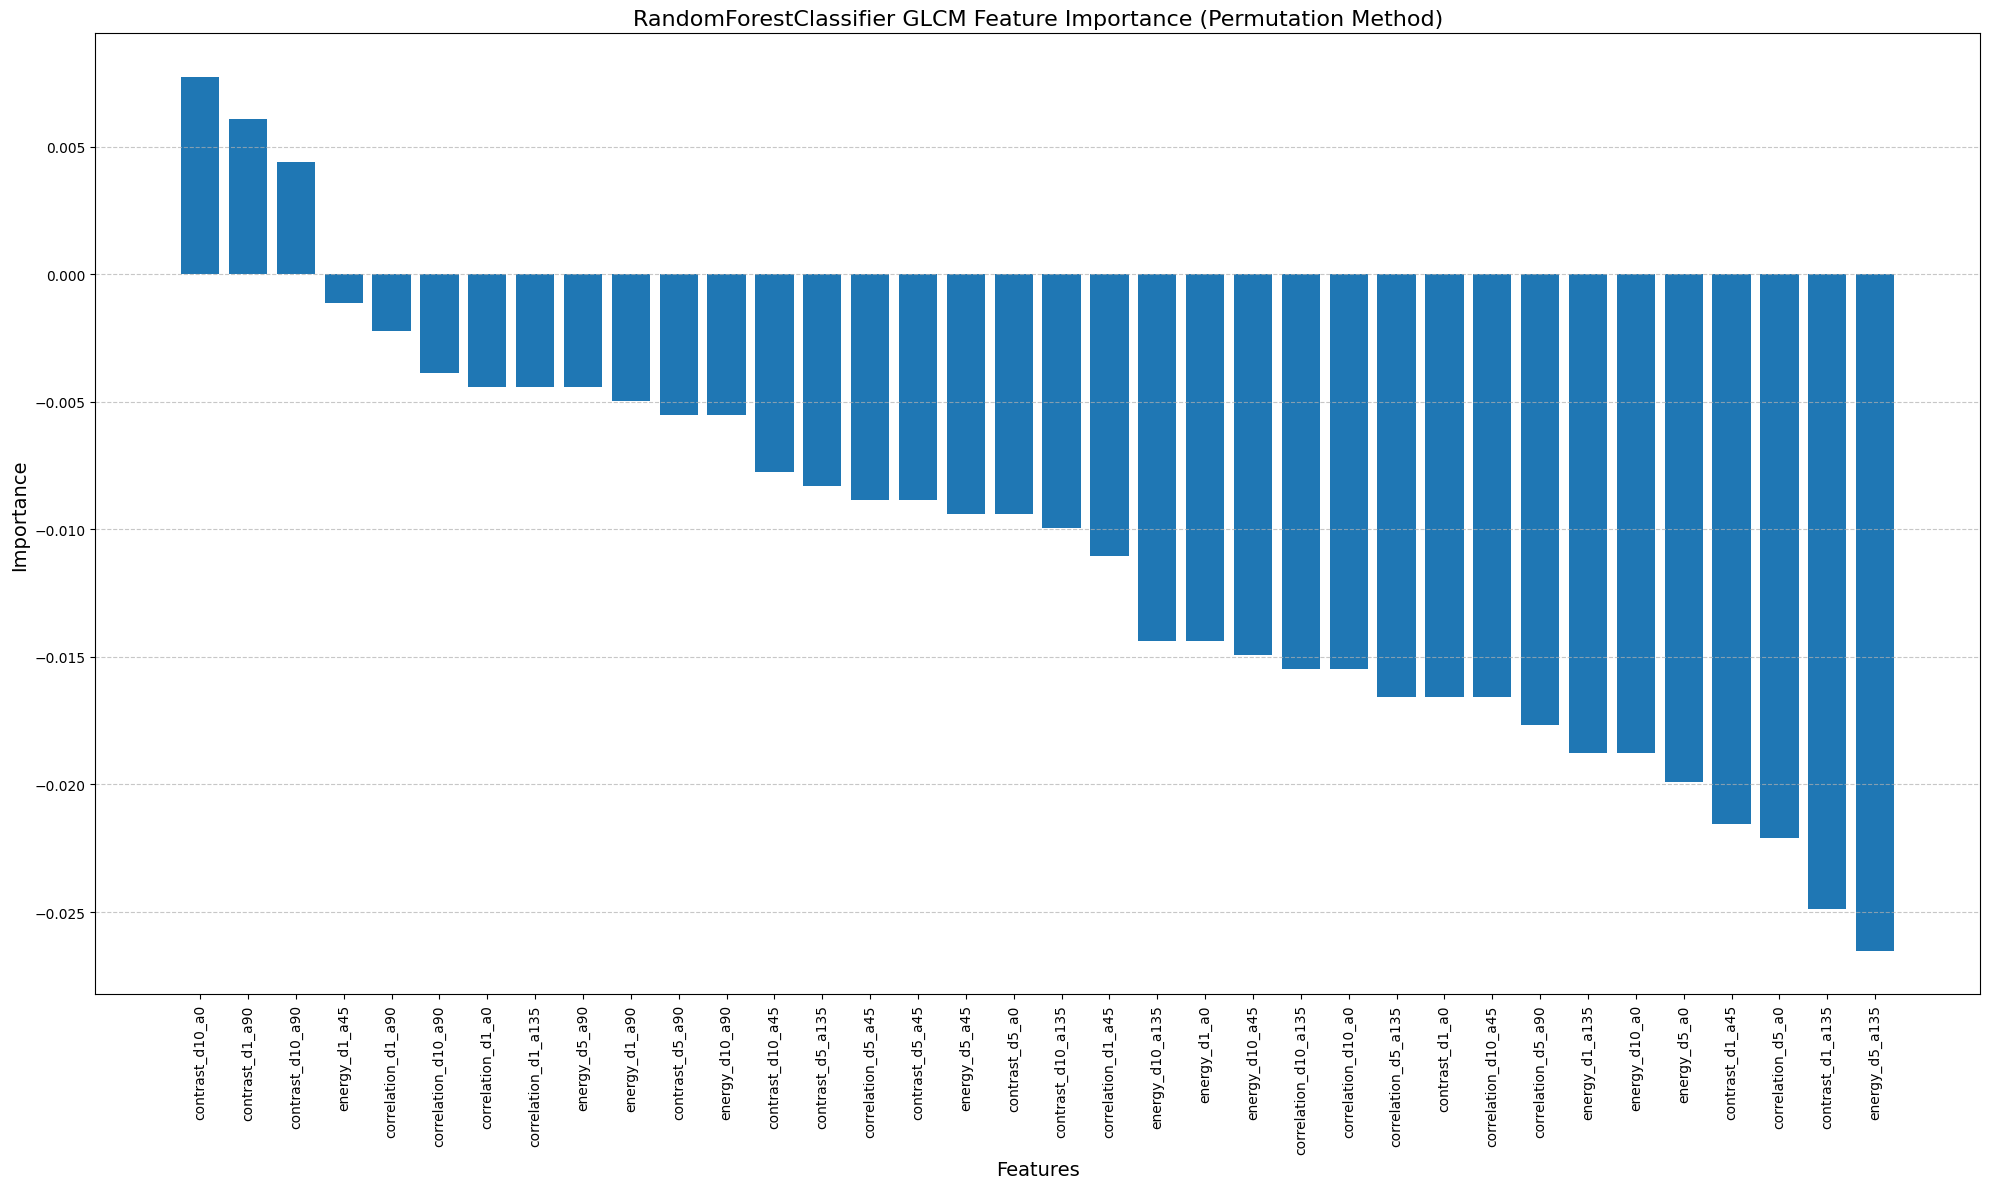

In [72]:
# permutation importance
result = permutation_importance(rf_glcm, X_test_glcm, y_test_glcm, n_repeats=10, random_state=RANDOM_STATE)
perm_importances = result.importances_mean

# Extract feature names from df
feature_names = glcm_df.drop(columns=['image_id', 'label']).columns.tolist()

# Sort features by importance
perm_indices = np.argsort(perm_importances)[::-1]

# plot feature importances 
show_feature_importance(rf_glcm, perm_importances, perm_indices, feature_names)

In [73]:
important_indices = [i for i, importance in enumerate(perm_importances) if importance > 0]
best_features = [feature_names[i] for i in important_indices]
print(f"Best features: {best_features}")

# slice to only positive features of X_train and X_test (y_train and y_test are uneffected)
X_train_glcm_rf = X_train_glcm[:, important_indices].copy()
X_test_glcm_rf = X_test_glcm[:, important_indices].copy()

Best features: ['contrast_d1_a90', 'contrast_d10_a0', 'contrast_d10_a90']


Optimal Hyperparameters:
{'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 148}

Optimal F1-macro score: 0.7980435092168563
RANDOM FOREST CLASSIFIER MODEL ANALYTICS
--------------------------------------------------
ROC-AUC Scores with OVR:
                ROC-AUC

    COVID-19     0.9578
      Normal     0.9474
   Pneumonia     0.9368

   macro avg     0.9473


Classification Report:
              precision    recall  f1-score   support

    COVID-19     0.8358    0.8485    0.8421        66
      Normal     0.8750    0.8000    0.8358        70
   Pneumonia     0.6800    0.7556    0.7158        45

    accuracy                         0.8066       181
   macro avg     0.7969    0.8013    0.7979       181
weighted avg     0.8122    0.8066    0.8083       181



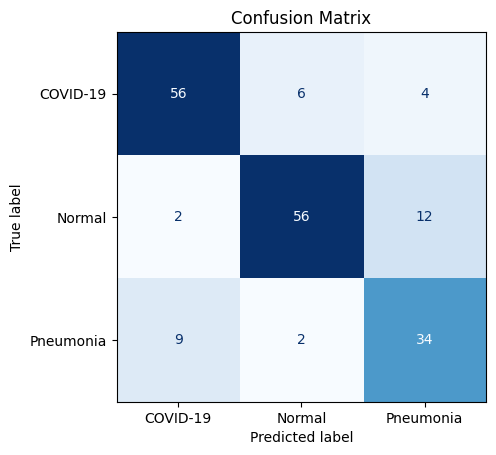

In [74]:
param_grid = {
    'max_depth': range(5, 101, 2),
    'max_features': ['sqrt', 'log2'],
    'n_estimators': range(50, 151, 2)
}

grid_search = GridSearchCV(
    rf_glcm, 
    param_grid=param_grid,
    cv=5, 
    scoring='f1_macro',
    n_jobs=-1
)

grid_search.fit(X_train_glcm_rf, y_train_glcm)

print("Optimal Hyperparameters:")
print(grid_search.best_params_)

print(f"\nOptimal F1-macro score: {grid_search.best_score_}")

# Set best estimator as model
rf_glcm_positive_only = grid_search.best_estimator_
# Get Results from Model
get_model_analytics(rf_glcm_positive_only, X_test_glcm_rf, y_test_glcm)

### SVM on GLCM Features
We train a linear Support Vector Machine (SVM) on the GLCM features and evaluate its classification performance.

SVC MODEL ANALYTICS
--------------------------------------------------
ROC-AUC Scores with OVR:
                ROC-AUC

    COVID-19     0.9644
      Normal     0.9650
   Pneumonia     0.9575

   macro avg     0.9623


Classification Report:
              precision    recall  f1-score   support

    COVID-19     0.9062    0.8788    0.8923        66
      Normal     0.9219    0.8429    0.8806        70
   Pneumonia     0.7170    0.8444    0.7755        45

    accuracy                         0.8564       181
   macro avg     0.8484    0.8554    0.8495       181
weighted avg     0.8652    0.8564    0.8587       181



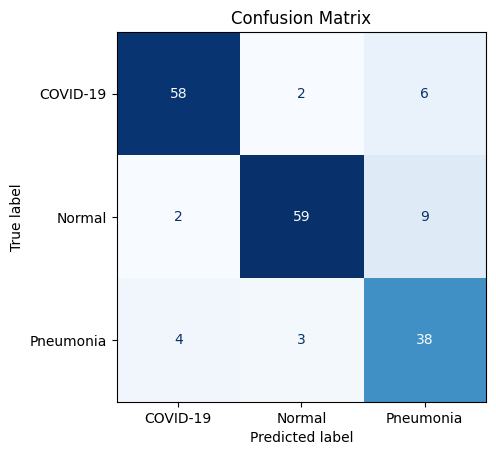

In [75]:
from sklearn.svm import SVC

svc_glcm = SVC(probability=True, class_weight='balanced', random_state=RANDOM_STATE)

# Train the classifier
svc_glcm.fit(X_train_glcm, y_train_glcm)
# Get Results from Model
get_model_analytics(svc_glcm, X_test_glcm, y_test_glcm)

Optimal Hyperparameters:
{'C': np.float64(10.0), 'degree': 2, 'gamma': np.float64(0.001), 'kernel': 'linear'}

Optimal F1-macro score: 0.8627284882083325
SVC MODEL ANALYTICS
--------------------------------------------------
ROC-AUC Scores with OVR:
                ROC-AUC

    COVID-19     0.9788
      Normal     0.9413
   Pneumonia     0.9557

   macro avg     0.9586


Classification Report:
              precision    recall  f1-score   support

    COVID-19     0.9508    0.8788    0.9134        66
      Normal     0.8939    0.8429    0.8676        70
   Pneumonia     0.7778    0.9333    0.8485        45

    accuracy                         0.8785       181
   macro avg     0.8742    0.8850    0.8765       181
weighted avg     0.8858    0.8785    0.8796       181



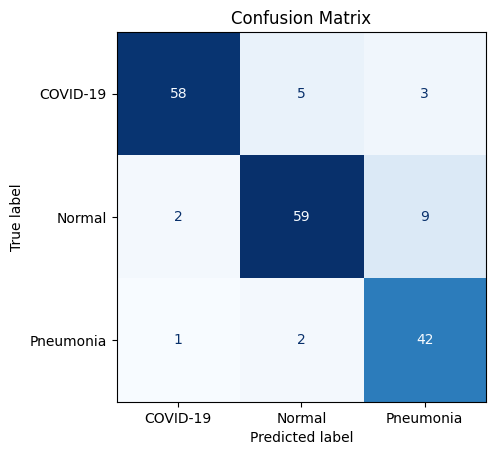

In [76]:
param_grid = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'C': np.logspace(-3, 3, 7),
    'gamma': np.logspace(-3, 3, 7),
    'degree': [2, 3, 4]
}

grid_search = GridSearchCV(
    svc_glcm,
    param_grid,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=0
)

grid_search.fit(X_train_glcm, y_train_glcm)

print("Optimal Hyperparameters:")
print(grid_search.best_params_)

print(f"\nOptimal F1-macro score: {grid_search.best_score_}")

# Set best estimator as model
svc_glcm = grid_search.best_estimator_
# Get Results from Model
get_model_analytics(svc_glcm, X_test_glcm, y_test_glcm)

Finer grid search with smaller parameter space

Optimal Hyperparameters:
{'C': np.float64(10.0), 'degree': 2, 'gamma': np.float64(0.001), 'kernel': 'linear'}

Optimal F1-macro score: 0.8627284882083325
SVC MODEL ANALYTICS
--------------------------------------------------
ROC-AUC Scores with OVR:
                ROC-AUC

    COVID-19     0.9788
      Normal     0.9413
   Pneumonia     0.9557

   macro avg     0.9586


Classification Report:
              precision    recall  f1-score   support

    COVID-19     0.9508    0.8788    0.9134        66
      Normal     0.8939    0.8429    0.8676        70
   Pneumonia     0.7778    0.9333    0.8485        45

    accuracy                         0.8785       181
   macro avg     0.8742    0.8850    0.8765       181
weighted avg     0.8858    0.8785    0.8796       181



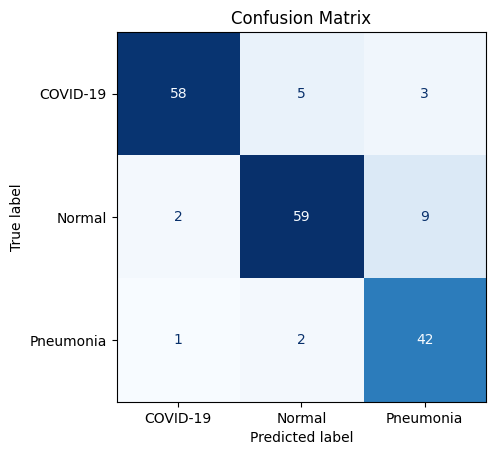

In [77]:
# Finer grid search around best values
fine_param_grid = {
    'C': np.logspace(2, 4, 10),  # Values between 100 and 10000
    'gamma': np.logspace(-4, -2, 10),  # Values around 0.001
    'kernel': ['rbf'],
    'class_weight': [None, 'balanced']  # Try with class weighting
}

fine_svm_gridsearch = GridSearchCV(
    svc_glcm,
    fine_param_grid,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=0
)

fine_svm_gridsearch.fit(X_train_glcm, y_train_glcm)

print("Optimal Hyperparameters:")
print(grid_search.best_params_)

print(f"\nOptimal F1-macro score: {grid_search.best_score_}")

# Set best estimator as model
svc_glcm = grid_search.best_estimator_
# Get Results from Model
get_model_analytics(svc_glcm, X_test_glcm, y_test_glcm)

Permutation Feature Importance on Best SVM Model

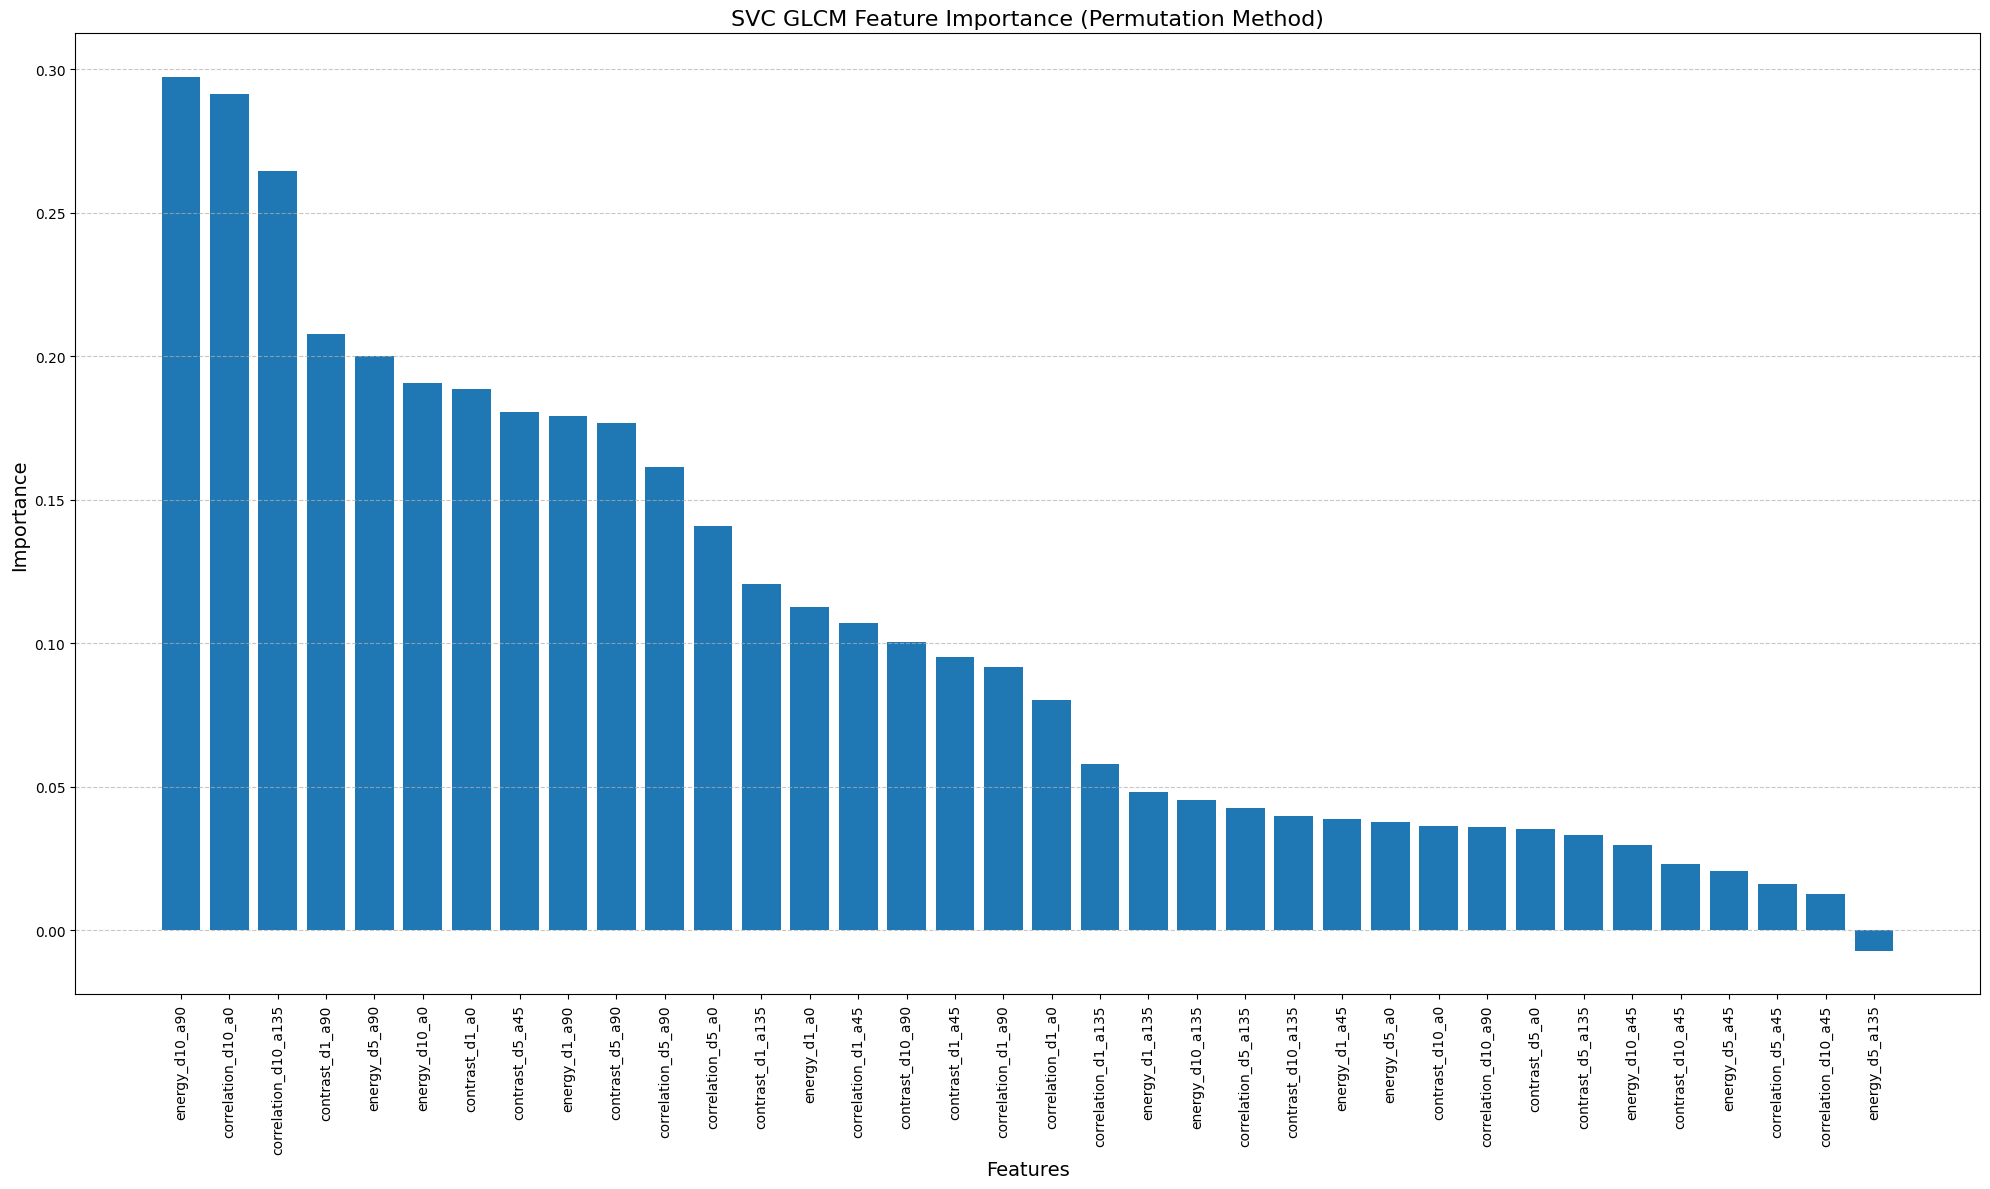

In [78]:
# permutation importance
result = permutation_importance(svc_glcm, X_test_glcm, y_test_glcm, n_repeats=10, random_state=RANDOM_STATE)
perm_importances = result.importances_mean

# Extract feature names from df
feature_names = glcm_df.drop(columns=['image_id', 'label']).columns.tolist()

# Sort features by importance
perm_indices = np.argsort(perm_importances)[::-1]

# plot feature importances 
show_feature_importance(svc_glcm, perm_importances, perm_indices, feature_names)

In [79]:
important_indices = [i for i, importance in enumerate(perm_importances) if importance > 0]
best_features = [feature_names[i] for i in important_indices]
print(f"Best features: {best_features}")

# slice to only positive features of X_train and X_test (y_train and y_test are uneffected)
X_train_glcm_svc = X_train_glcm[:, important_indices].copy()
X_test_glcm_svc = X_test_glcm[:, important_indices].copy()

Best features: ['contrast_d1_a0', 'contrast_d1_a45', 'contrast_d1_a90', 'contrast_d1_a135', 'contrast_d5_a0', 'contrast_d5_a45', 'contrast_d5_a90', 'contrast_d5_a135', 'contrast_d10_a0', 'contrast_d10_a45', 'contrast_d10_a90', 'contrast_d10_a135', 'energy_d1_a0', 'energy_d1_a45', 'energy_d1_a90', 'energy_d1_a135', 'energy_d5_a0', 'energy_d5_a45', 'energy_d5_a90', 'energy_d10_a0', 'energy_d10_a45', 'energy_d10_a90', 'energy_d10_a135', 'correlation_d1_a0', 'correlation_d1_a45', 'correlation_d1_a90', 'correlation_d1_a135', 'correlation_d5_a0', 'correlation_d5_a45', 'correlation_d5_a90', 'correlation_d5_a135', 'correlation_d10_a0', 'correlation_d10_a45', 'correlation_d10_a90', 'correlation_d10_a135']


Optimal Hyperparameters:
{'C': np.float64(10000.0), 'gamma': np.float64(0.0002782559402207126), 'kernel': 'rbf'}

Optimal F1-macro score: 0.8589292114320157
SVC MODEL ANALYTICS
--------------------------------------------------
ROC-AUC Scores with OVR:
                ROC-AUC

    COVID-19     0.9798
      Normal     0.9336
   Pneumonia     0.9505

   macro avg     0.9546


Classification Report:
              precision    recall  f1-score   support

    COVID-19     0.9531    0.9242    0.9385        66
      Normal     0.9333    0.8000    0.8615        70
   Pneumonia     0.7719    0.9778    0.8627        45

    accuracy                         0.8895       181
   macro avg     0.8861    0.9007    0.8876       181
weighted avg     0.9004    0.8895    0.8899       181



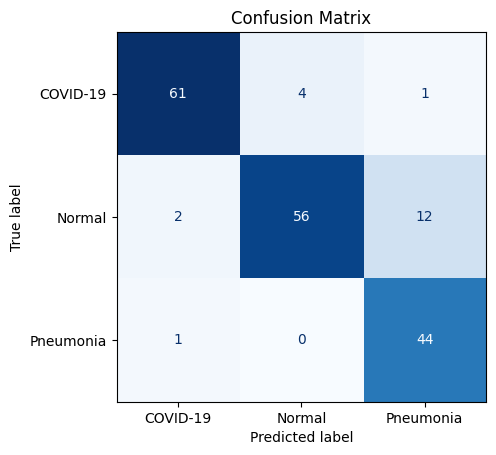

In [80]:
# Finer grid search around best values
fine_param_grid = {
    'C': np.logspace(2, 4, 10),  # Values between 100 and 10000
    'gamma': np.logspace(-4, -2, 10),  # Values around 0.001
    'kernel': ['rbf']
}

fine_svm_gridsearch = GridSearchCV(
    svc_glcm,
    fine_param_grid,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=0
)

fine_svm_gridsearch.fit(X_train_glcm_svc, y_train_glcm)

print("Optimal Hyperparameters:")
print(fine_svm_gridsearch.best_params_)

print(f"\nOptimal F1-macro score: {fine_svm_gridsearch.best_score_}")

# Set best estimator as model
svc_glcm_positive_only = fine_svm_gridsearch.best_estimator_
# Get Results from Model
get_model_analytics(svc_glcm_positive_only, X_test_glcm_svc, y_test_glcm)

### k-Nearest Neighbors on GLCM Features
k-NN is tested again, this time using the texture-based features extracted from GLCM.

K NEIGHBORS CLASSIFIER MODEL ANALYTICS
--------------------------------------------------
ROC-AUC Scores with OVR:
                ROC-AUC

    COVID-19     0.9164
      Normal     0.9401
   Pneumonia     0.8939

   macro avg     0.9168


Classification Report:
              precision    recall  f1-score   support

    COVID-19     0.9153    0.8182    0.8640        66
      Normal     0.8228    0.9286    0.8725        70
   Pneumonia     0.7442    0.7111    0.7273        45

    accuracy                         0.8343       181
   macro avg     0.8274    0.8193    0.8213       181
weighted avg     0.8370    0.8343    0.8333       181



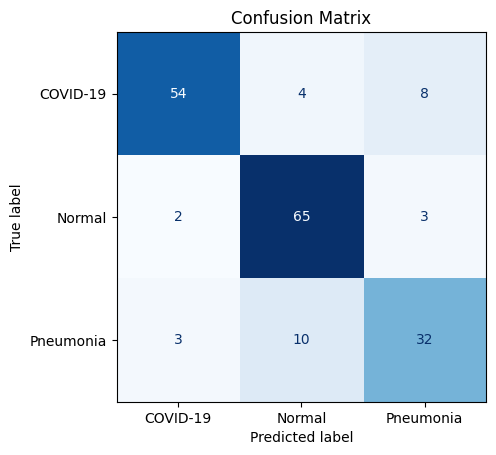

In [81]:
from sklearn.neighbors import KNeighborsClassifier

knn_glcm = KNeighborsClassifier()

# Train the classifier
knn_glcm.fit(X_train_glcm, y_train_glcm)
# Get Results from Model
get_model_analytics(knn_glcm, X_test_glcm, y_test_glcm)

Optimal Hyperparameters:
{'algorithm': 'auto', 'metric': 'euclidean', 'n_neighbors': 8, 'weights': 'distance'}

Optimal F1-macro score: 0.764690446124464
K NEIGHBORS CLASSIFIER MODEL ANALYTICS
--------------------------------------------------
ROC-AUC Scores with OVR:
                ROC-AUC

    COVID-19     0.9372
      Normal     0.9532
   Pneumonia     0.9039

   macro avg     0.9314


Classification Report:
              precision    recall  f1-score   support

    COVID-19     0.9455    0.7879    0.8595        66
      Normal     0.8205    0.9143    0.8649        70
   Pneumonia     0.6875    0.7333    0.7097        45

    accuracy                         0.8232       181
   macro avg     0.8178    0.8118    0.8113       181
weighted avg     0.8330    0.8232    0.8243       181



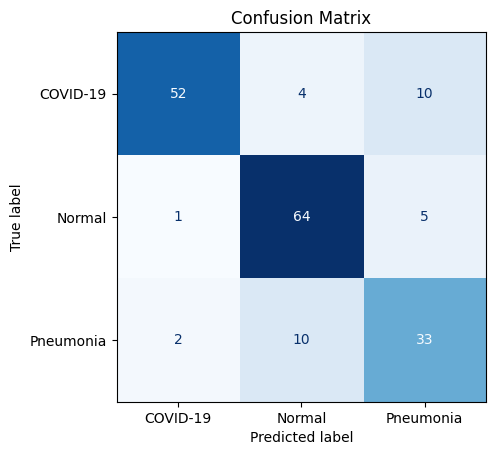

In [82]:
param_grid = {
    'n_neighbors': range(3, 20),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}
grid_search = GridSearchCV(
    knn_glcm, 
    param_grid=param_grid, 
    cv=5, 
    scoring='f1_macro', 
    n_jobs=-1, 
    verbose=0
)

grid_search.fit(X_train_glcm, y_train_glcm)

# Print the best hyperparameters and the corresponding score
print("Optimal Hyperparameters:")
print(grid_search.best_params_)

print(f"\nOptimal F1-macro score: {grid_search.best_score_}")

# Use the best model from the grid search
knn_glcm = grid_search.best_estimator_

# Get Results from the optimized model
get_model_analytics(knn_glcm, X_test_glcm, y_test_glcm)

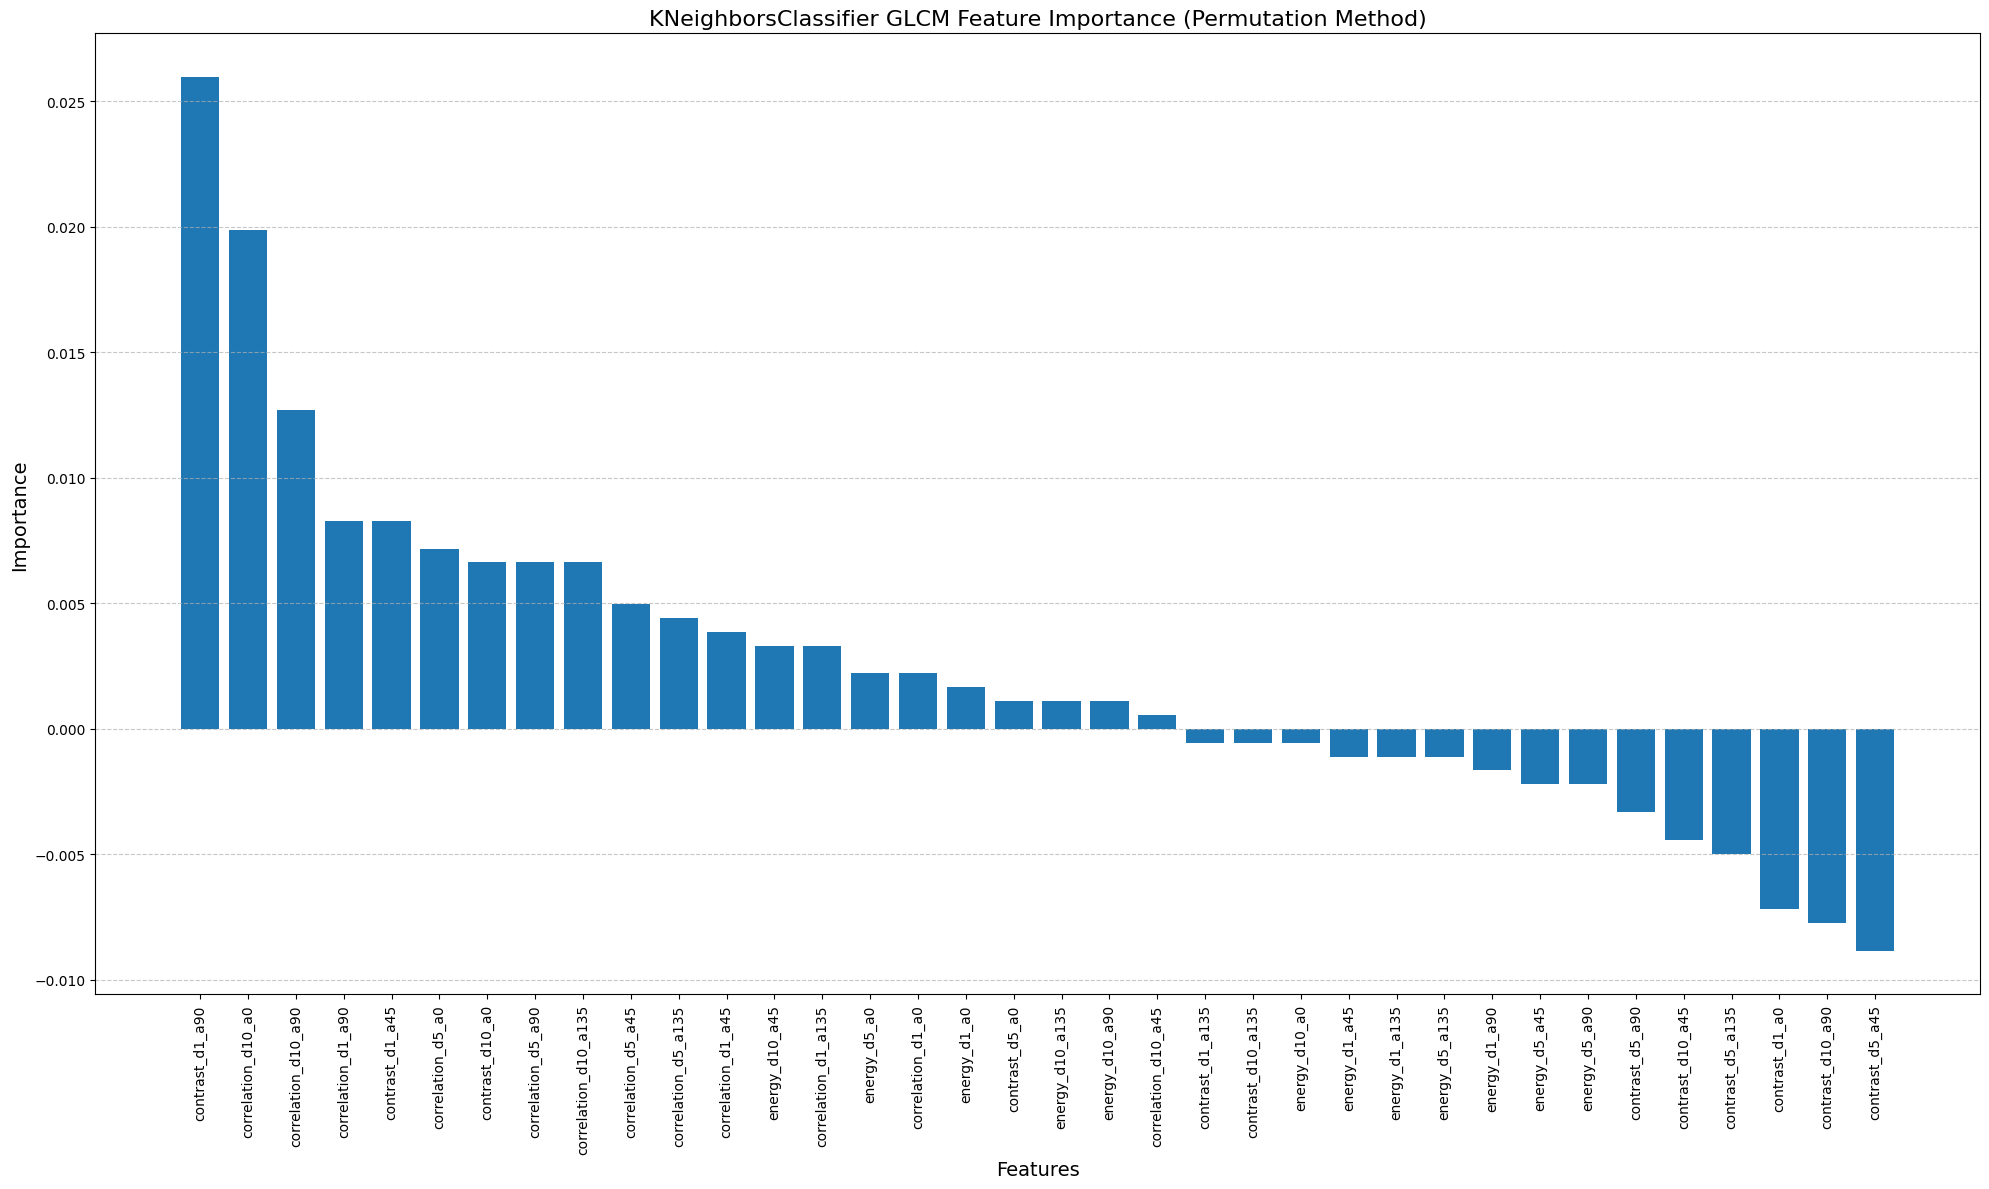

In [83]:
# permutation importance
result = permutation_importance(knn_glcm, X_test_glcm, y_test_glcm, n_repeats=10, random_state=RANDOM_STATE)
perm_importances = result.importances_mean

# Extract feature names from df
feature_names = glcm_df.drop(columns=['image_id', 'label']).columns.tolist()

# Sort features by importance
perm_indices = np.argsort(perm_importances)[::-1]

# plot feature importances 
show_feature_importance(knn_glcm, perm_importances, perm_indices, feature_names)

In [84]:
important_indices = [i for i, importance in enumerate(perm_importances) if importance > 0]
best_features = [feature_names[i] for i in important_indices]
print(f"Best features: {best_features}")

# slice to only positive features of X_train and X_test (y_train and y_test are uneffected)
X_train_glcm_knn = X_train_glcm[:, important_indices].copy()
X_test_glcm_knn = X_test_glcm[:, important_indices].copy()

Best features: ['contrast_d1_a45', 'contrast_d1_a90', 'contrast_d5_a0', 'contrast_d10_a0', 'energy_d1_a0', 'energy_d5_a0', 'energy_d10_a45', 'energy_d10_a90', 'energy_d10_a135', 'correlation_d1_a0', 'correlation_d1_a45', 'correlation_d1_a90', 'correlation_d1_a135', 'correlation_d5_a0', 'correlation_d5_a45', 'correlation_d5_a90', 'correlation_d5_a135', 'correlation_d10_a0', 'correlation_d10_a45', 'correlation_d10_a90', 'correlation_d10_a135']


Optimal Hyperparameters:
{'algorithm': 'auto', 'metric': 'manhattan', 'n_neighbors': 6, 'weights': 'distance'}

Optimal F1-macro score: 0.8090564385528264
K NEIGHBORS CLASSIFIER MODEL ANALYTICS
--------------------------------------------------
ROC-AUC Scores with OVR:
                ROC-AUC

    COVID-19     0.9461
      Normal     0.9488
   Pneumonia     0.9242

   macro avg     0.9397


Classification Report:
              precision    recall  f1-score   support

    COVID-19     0.9464    0.8030    0.8689        66
      Normal     0.8148    0.9429    0.8742        70
   Pneumonia     0.7727    0.7556    0.7640        45

    accuracy                         0.8453       181
   macro avg     0.8447    0.8338    0.8357       181
weighted avg     0.8523    0.8453    0.8449       181



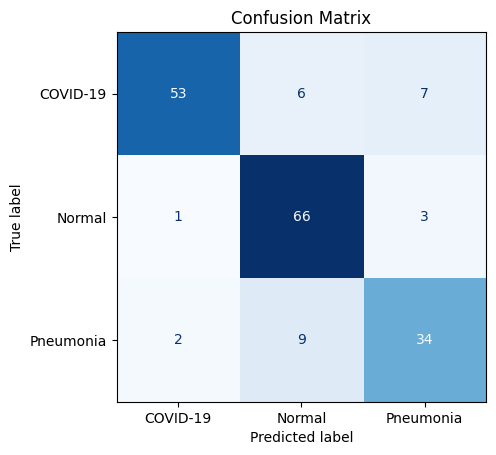

In [85]:
param_grid = {
    'n_neighbors': range(3, 20),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}
grid_search = GridSearchCV(
    knn_glcm, 
    param_grid=param_grid, 
    cv=5, 
    scoring='f1_macro', 
    n_jobs=-1, 
    verbose=0
)

grid_search.fit(X_train_glcm_knn, y_train_glcm)

# Print the best hyperparameters and the corresponding score
print("Optimal Hyperparameters:")
print(grid_search.best_params_)

print(f"\nOptimal F1-macro score: {grid_search.best_score_}")

# Use the best model from the grid search
knn_glcm_positive_only = grid_search.best_estimator_

# Get Results from the optimized model
get_model_analytics(knn_glcm_positive_only, X_test_glcm_knn, y_test_glcm)

# Results

In [94]:
# Flat Data Row
output_columns = []
print("FLATTENED DATA MODELS")
run_model_analytics_in_column(lr_flat, X_test_flat, y_test_flat, output_columns)
run_model_analytics_in_column(rf_flat, X_test_flat, y_test_flat, output_columns)
run_model_analytics_in_column(svc_flat, X_test_flat, y_test_flat, output_columns)
run_model_analytics_in_column(knn_flat, X_test_flat, y_test_flat, output_columns)
show_model_analytics_columns(output_columns)

# GLCM Data Row
output_columns = []
print("GLCM DATA MODELS")
run_model_analytics_in_column(lr_glcm, X_test_glcm, y_test_glcm, output_columns)
run_model_analytics_in_column(rf_glcm, X_test_glcm, y_test_glcm, output_columns)
run_model_analytics_in_column(svc_glcm, X_test_glcm, y_test_glcm, output_columns)
run_model_analytics_in_column(knn_glcm, X_test_glcm, y_test_glcm, output_columns)
show_model_analytics_columns(output_columns)

# GLCM Data Positive Features Only Row
output_columns = []
print("GLCM DATA WITH POSITIVE FEATURES ONLY")
run_model_analytics_in_column(lr_glcm_positive_only, X_test_glcm_lr, y_test_glcm, output_columns)
run_model_analytics_in_column(rf_glcm_positive_only, X_test_glcm_rf, y_test_glcm, output_columns)
run_model_analytics_in_column(svc_glcm_positive_only, X_test_glcm_svc, y_test_glcm, output_columns)
run_model_analytics_in_column(knn_glcm_positive_only, X_test_glcm_knn, y_test_glcm, output_columns)
show_model_analytics_columns(output_columns)

# Best Model from each set
output_columns = []
print("BEST MODEL FROM EACH SET")
run_model_analytics_in_column(lr_flat, X_test_flat, y_test_flat, output_columns)
run_model_analytics_in_column(svc_glcm, X_test_glcm, y_test_glcm, output_columns)
run_model_analytics_in_column(svc_glcm_positive_only, X_test_glcm_svc, y_test_glcm, output_columns)
show_model_analytics_columns(output_columns, 3)

FLATTENED DATA MODELS


GLCM DATA MODELS


GLCM DATA WITH POSITIVE FEATURES ONLY


BEST MODEL FROM EACH SET


## Saving est model from each section

In [ ]:
import joblib

joblib.dump(lr_flat, "models/lr_flat_best.pkl")
joblib.dump(svc_glcm, "models/svc_glcm_best.pkl")
joblib.dump(svc_glcm_positive_only, "models/svc_glcm_positive_only_best.pkl")

['models/svc_glcm_positive_only_best.pkl']

# Summary

We've explored a machine learning approach to classifying chest X-ray images into one of three categories (COVID-19, Pneumonia, and Normal). Using a dataset sourced from Mendeley, we implemented a pipeline involving image cleaning (using Roboflow, Appendix A: Figs. A.1-A.2), pixel and texture-based feature extraction (using GLCM), and the application of several classification algorithms including Random Forest Classification, Support Vector Classification (SVC), k-Nearest Neighbors (k-NN) and Logistic Regression. We then compared raw pixel-based features with GLCM-based features by evaluating multiple classifiers with hyperparameter tuning on both approaches. Our results demonstrate that GLCM-based features yield superior classification performance, with the SVC model achieving the highest accuracy.

The logistic regression model achieved the highest accuracy (88.4%), macro F1-score (0.8825), and macro ROC-AUC (0.9733) on the raw-pixel approach (Appendix B: Figs. B.1-B.2).

On the full GLCM feature set, the SVC model performed best. It achieved an accuracy of 87.9%, macro F1-score of 0.8765, and macro ROC-AUC of 0.9586 (Appendix B: Figs. B.3-B.4).

Lastly, using only the most informative GLCM features (based on permutation importance, Appendix C: Fig. C.1), the SVC model once again performed the best. It achieved an accuracy of 88.95%, macro F1-score of 0.8876, and macro ROC-AUC of 0.9546. Its confusion matrix demonstrates excellent COVID-19 precision and near-perfect Pneumonia recall (Appendix B: Figs. B.5-B.6).

The SVC model on the selected GLCM features achieved the best overall performance. It achieved the highest accuracy, macro F1-score, and macro ROC-AUC across all experiments. This model demonstrated consistent performance across all three classes and is therefore the most suitable for deployment or further development (Appendix B: Figs. B.5–B.6; Appendix C: Fig. C.1).